# **Import libraries**

In [39]:
# Import Libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
!pip install mne
import mne
from math import floor
import librosa

# Music and data imports
from scipy.signal import resample_poly
from scipy.signal import hilbert
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Model imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, Conv2DTranspose
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# Import the library to mount Google Drive
from google.colab import drive


# **Mount data**

In [2]:
# Mount Data
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Verify by listing the files in the drive
!ls "/content/drive/My Drive/CMPT 491 EEG Data"

derivatives  envelope_resampled_good.npy  preprocessedFifs  songs.tsv


Global Variables

In [3]:
# GLOBALS
#good_participants_index = [0, 1, 5, 6, 9, 11, 13, 18, 19, 21, 23, 25, 26] # 8 is removed
#good_participants =  [1, 2, 6, 7, 11, 13, 15, 20, 21, 23, 25, 27, 28]
#good_participants = [1,2]
good_participants = [30]

SONG_LENGTH = 2048 # 4.096 seconds
TIME_PADDING = 250 # in samples, 500ms for reaction time
SF = 500 # Sampling frequency, in Hz
OFFSET = 500

RANDOM_SEED = 45
np.random.seed(RANDOM_SEED)  # for reproducibility

# Import music & EEG data

In [16]:
raw_array = []
participants = []
for i in(good_participants):

  participant_id = str(i).zfill(2)
  participants.append(f"sub-{participant_id}")
  # read raw eeg
  raw =  mne.io.read_raw_fif(
    f"/content/drive/My Drive/CMPT 491 EEG Data/preprocessedFifs/sub-{participant_id}/sub-{participant_id}_task-songfamiliarity_eeg_preprocessed-raw.fif"
  ,preload=False)
  raw_array.append(raw)

print(participants)

Opening raw data file /content/drive/My Drive/CMPT 491 EEG Data/preprocessedFifs/sub-30/sub-30_task-songfamiliarity_eeg_preprocessed-raw.fif...
    Range : 0 ... 994574 =      0.000 ...  1989.148 secs
Ready.
['sub-30']


# Analyze EEG components

In [ ]:
sub_id = participants[0]
raw = raw_array[0]

print("Raw: ", raw)
print("Raw info: ", raw.info)

print("Channel names:", raw.ch_names)
print("Duration (s):", raw.n_times / raw.info["sfreq"])
#print("Channel types:", raw.get_channel_types()) #EEG



Raw:  <Raw | sub-01_task-songfamiliarity_eeg_preprocessed-raw.fif, 30 x 903550 (1807.1 s), ~41 KiB, data not loaded>
Raw info:  <Info | 11 non-empty values
 bads: []
 ch_names: O1, P7, P3, CP5, CP1, T7, C3, FC1, FC5, F3, F7, Fp1, O2, P8, P4, ...
 chs: 30 EEG
 custom_ref_applied: True
 dig: 35 items (3 Cardinal, 32 EEG)
 file_id: 4 items (dict)
 highpass: 0.2 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 30
 projs: []
 sfreq: 500.0 Hz
>
Channel names: ['O1', 'P7', 'P3', 'CP5', 'CP1', 'T7', 'C3', 'FC1', 'FC5', 'F3', 'F7', 'Fp1', 'O2', 'P8', 'P4', 'CP6', 'CP2', 'C4', 'T8', 'FC2', 'FC6', 'F4', 'F8', 'Fp2', 'Oz', 'Pz', 'CPz', 'Cz', 'FCz', 'AFz']
Duration (s): 1807.1


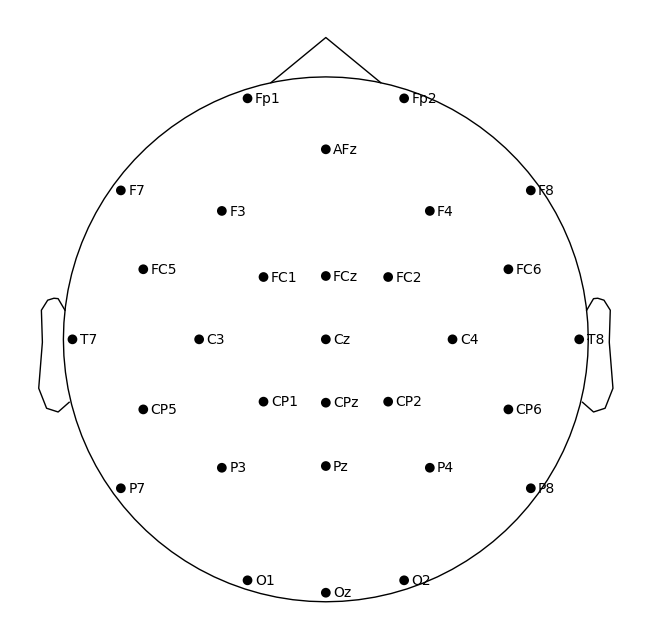

In [ ]:

fig = mne.viz.plot_sensors(
    raw.info,
    kind='topomap',
    show_names=True,
    sphere=0.09,        # standard head size for EEG
    ch_type='eeg'
)
fig.set_size_inches(6, 6)

In [ ]:
# raw is your Raw object
data = raw.get_data()  # shape: (n_channels, n_times)
print(data.shape)

(30, 917825)


# **Import song data**

In [ ]:
song_data = pd.read_csv("/content/drive/My Drive/CMPT 491 EEG Data/songs.tsv", sep="\t")
song_durations = song_data["end"] - song_data["start"] # in samples
song_durations.describe()


count    2074.000000
mean     3779.342334
std      1668.058829
min       784.000000
25%      2322.000000
50%      3791.000000
75%      4898.000000
max      8783.000000
dtype: float64

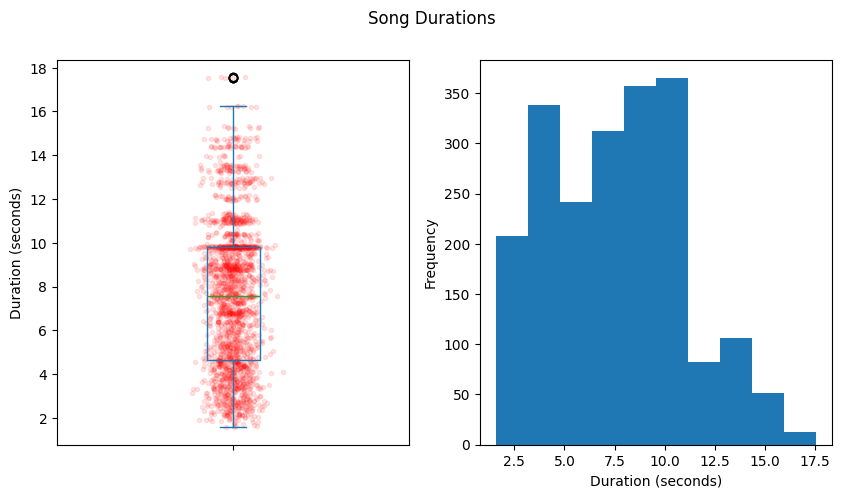

In [ ]:
# Plot song durations

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Song Durations")

x = np.random.normal(1, 0.04, size=len(song_durations))
ax[0].plot(x, song_durations/SF, "r.", alpha=0.1)
(song_durations/SF).plot.box(ax=ax[0])
ax[0].set_ylabel("Duration (seconds)")
(song_durations/SF).plot.hist(ax=ax[1])
ax[1].set_xlabel("Duration (seconds)")
plt.show()

# **Filter out songs shorter than song length**

In [ ]:
# Filter out songs shorter than the specified duration with padding

min_duration = SONG_LENGTH
padding = TIME_PADDING

filtered_song_data = song_data[song_durations >= min_duration + padding].reset_index(
    drop=True
)
song_durations[song_durations >= min_duration + padding].head()
# number of songs for subject:
print(len(filtered_song_data[
    (filtered_song_data['participant_id'] == 'sub-01') &
    (filtered_song_data['identification'] == False)])
)

print(song_data)
print(filtered_song_data)


19
     participant_id  note_onset                                 stim_file  \
0            sub-01         NaN                          do wah ditty.wav   
1            sub-01         NaN                              alouette.wav   
2            sub-01         NaN                          great escape.wav   
3            sub-01         NaN                          buffalo gals.wav   
4            sub-01         NaN  over the river and through the woods.wav   
...             ...         ...                                       ...   
2069         sub-30         NaN           michael row the boat ashore.wav   
2070         sub-30         NaN                mary had a little lamb.wav   
2071         sub-30         NaN                    smoke on the water.wav   
2072         sub-30         NaN                               peanuts.wav   
2073         sub-30         NaN                      down in my heart.wav   

         start       end  identification  button_press  
0       9354.0 

## **Data selection and creation**

In [ ]:
# Loop through each song entry that belongs to a known participant
# Param: offset - Number of samples to shift back start and "end" point
def create_signal_EEG():
    padding_samples = padding     # 0.5 seconds
    signal_segments = []


    for _, song in filtered_song_data[filtered_song_data["participant_id"].isin(filtered_Participants)].iterrows():
        participant_index = filtered_Participants.index(song["participant_id"])
        participant_signal = participant_signals[participant_index]


        # We should stick to samples rather than time
        index = int(song["end"])
        index = index-padding_samples # To pad reaction time of button press
        start = int(song["start"])
        song_length_samples = SONG_LENGTH    # 4.096 seconds
        increment_samples = OFFSET    # 1 seconds
        # This operates based on the assumption that nothing shorter than 3 seconds remains
        while(True):

          # BREAK LOGIC (fixed)
          if index <= start + song_length_samples:
              print("GET ME OUT!!!")
              break

          slice_segment = participant_signal[:, index - song_length_samples : index]

          # Check shape before appending
          if slice_segment.shape[1] != song_length_samples:
              print(f"Culprit detected! participant {song['participant_id']}, index {index}, slice shape {slice_segment.shape}")

          # Add batch dimension
          expanded_segment = np.expand_dims(slice_segment, axis=0)
          signal_segments.append(expanded_segment)
          #print(expanded_segment)
          index -= increment_samples
          if(index-song_length_samples < start): break

    # NEED TO CONVERT TO TENSOR DATA OBJECT
    # please work
    return tf.constant(signal_segments, dtype=tf.float32)

In [ ]:
# Because we are indexing from the end to the start of a song we do not actually need to 0 out
# any bad epochs or moments where there is no playback. Instead we simply drop songs which are
# within bad epochs. Then use the songs.tsv file to index through the EEG and music data

# can filter for specific participants here
#   by index - [[0, 1, 2]]
#   by range - [start:end]
#   all - [:] (same as removing indexing)

# list of subjects
# good_participants =  [1, 2, 6, 7, 8, 11, 13, 15, 20, 21, 23, 25, 27, 28]
good_ids = ['sub-' + str(i).zfill(2) for i in good_participants]
participants = filtered_song_data["participant_id"].unique()

filtered_Participants = [p for p in participants if p in good_ids]
#print(filtered_Participants)
# load EEG signals for the participants
participant_signals = []
for participant_id in filtered_Participants:
    # get raw signal from raw array
    raw = raw_array[filtered_Participants.index(participant_id)]
    # Get start and stop sample points (indicies) for bad epochs
    annotations = raw.annotations.copy()
    bad_epochs_start = []
    bad_epochs_stop = []
    for bad_epoch in annotations:
        bad_epochs_start.append(int(bad_epoch['onset'])*SF) # Start time
        bad_epochs_stop.append(int((bad_epoch['onset'] + bad_epoch['duration']))*SF)# End time

    # Create numpy mask, starting with 0 nparray
    #raw[0].get_data() -> (30, 903550)
    n_channels, n_samples = raw.get_data().shape
    remove_mask = np.zeros(n_samples, dtype=bool)

    # load raw data into memory
    raw.load_data() # may not need to occure


    # Assign mask values
    for i in range (len(annotations)):
        remove_mask[bad_epochs_start[i]:bad_epochs_stop[i]] = True
    raw._data[:, remove_mask] = 0 # for each of the 30 cannels, set remove_mask sections to 0
    # Remove any song_data events that contain bad_epoch (True) sections
    song_starts = []
    song_ends = []
    drop_rows = []
    for i in range(len(filtered_song_data)):
        song_start_info = filtered_song_data.iloc[i]
        if song_start_info['participant_id'] == participant_id:
            song_starts.append(int(song_start_info['start']))
            song_ends.append(int(song_start_info['end']))

            # Currently we are removing all songs which contain any bad epochs
            # Epochs are 20 seconds in length.
            # bad epoch criteria -> reject_criteria = dict(eeg=550e-6)
            # Songs are from 4 seconds to 17 seconds long
            if remove_mask[int(song_start_info["start"]):int(song_start_info["end"])].any():
                # remove filtered_song_data row
                drop_rows.append(i)
                #print("adding: ", song_start_info['stim_file'], " to remove list")
    # Dropping all song entries which are in the boundary of a bad epoch.
    filtered_song_data = filtered_song_data.drop(index=drop_rows).reset_index(drop=True)
    print("\n\n removed count: ", len(drop_rows))


    # ===== Here we slice our eeg and music data according to playback =====
    participant_signals.append(raw.get_data())

# cut out the signals for each individual songs
print("Made it to create signal!")
signal = create_signal_EEG()

Reading 0 ... 994574  =      0.000 ...  1989.148 secs...


 removed count:  8
Made it to create signal!


In [ ]:
# Export Signal
serialized = tf.io.serialize_tensor(signal)
tf.io.write_file("tensor.tfrecord", serialized)

from google.colab import files
files.download("tensor.tfrecord")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

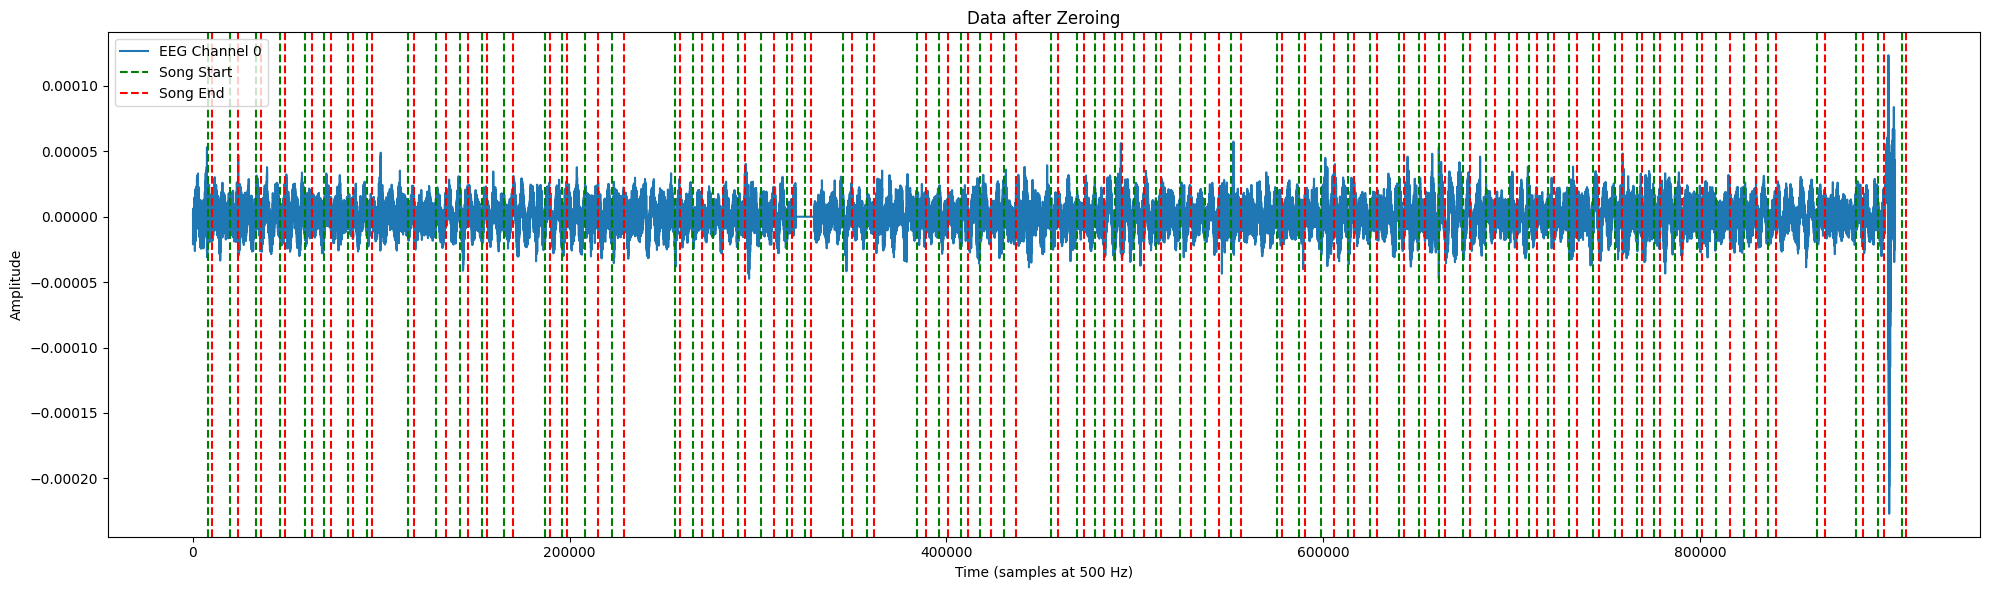

In [ ]:
# Plot the figure:
# Shows annotations
plt.figure(figsize=(20,6))
# Plot EEG signal (first channel)
plt.plot(raw_array[0].get_data()[0].T, label='EEG Channel 0')

# Add vertical lines for song starts (green)
for start in song_starts:
    plt.axvline(x=start, color='green', linestyle='--', label='Song Start')
# Add vertical lines for song ends (red)
for end in song_ends:
    plt.axvline(x=end, color='red', linestyle='--', label='Song End')

plt.title('Data after Zeroing')
plt.xlabel('Time (samples at 500 Hz)')
plt.ylabel('Amplitude')

# Show legend (only once per label)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # remove duplicates
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()


# Import Tensor to Skip Data Processing


In [4]:
raw_tensor = tf.io.read_file("/content/drive/My Drive/CMPT 491 EEG Data/2048_good.tfrecord")
signal = tf.io.parse_tensor(raw_tensor, out_type=tf.float32)


# Data split for training and validation

In [6]:
# shuffle the dataset to ensure that the train, validation, and test sets are representative of the entire dataset.
# bacuase the datset is somewhat balanced, random sampling should be 'good enough'
#
# generating the splits once and save them to avoid shuffling every time and ensure reproducibility is a better option
shuffle = np.random.permutation(len(signal))
print(signal.shape)

split = (0.70, 0.1, 0.2)
train_size = int(len(signal) * split[0])
val_size   = int(len(signal) * split[1])
test_size  = len(signal) - train_size - val_size

train_idxs = shuffle[:train_size]
val_idxs   = shuffle[train_size:train_size + val_size]
test_idxs  = shuffle[train_size + val_size:]

train_signal = tf.gather(signal, tf.convert_to_tensor(train_idxs, dtype=tf.int32))
val_signal   = tf.gather(signal, tf.convert_to_tensor(val_idxs, dtype=tf.int32))
test_signal  = tf.gather(signal, tf.convert_to_tensor(test_idxs, dtype=tf.int32))

# expected shape=(None, 30, 1500, 1)
train_signal = np.transpose(train_signal, (0, 2, 3, 1))
test_signal  = np.transpose(test_signal, (0, 2, 3, 1))
val_signal   = np.transpose(val_signal, (0, 2, 3, 1))
# (batch, height, width, channels)
print(train_signal.shape) # (2361, 30, 1500, 1)




(2690, 1, 30, 2048)
(1882, 30, 2048, 1)


In [7]:
# Scale each channel to [-1, 1]
# https://en.wikipedia.org/wiki/Feature_scaling
# NOTE - We should try a reconstruction on a subject not seen at all!! maybe 30
min_val = train_signal.min(axis=(0,2), keepdims=True)
max_val = train_signal.max(axis=(0,2), keepdims=True)

test_signal_norm  = 2 * (test_signal - min_val) / (max_val - min_val + 1e-8) -1
train_signal_norm = 2 * (train_signal - min_val) / (max_val - min_val + 1e-8) - 1
val_signal_norm   = 2 * (val_signal - min_val) / (max_val - min_val + 1e-8) - 1


# DeepConvEEGNet Architecture

In [ ]:
def DeepConvEEGNet(nb_classes, Chans = 30, Samples = SONG_LENGTH,
                dropoutRate = 0.1):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.

    We have a sampling frequency of 500hz so I think we just double everything.

    original -> 500 samples (250hz * 2 seconds)
    ours -> 2048 samples
    army -> 256 samples x0.5 (128hz * 2 seconds)

                    army        original paper    ours
    pool_size        1, 2        1, 3             1,4
    strides          1, 2        1, 3             1,4
    conv filters     1, 5        1, 10            1,20



    Note that this implementation has not been verified by the original
    authors.

    """

    # start the model 30 × 2048 × 1 = 61,440 values
    input_main   = Input((Chans, Samples, 1))
    print("Input shape:", input_main.shape)

    # Encoder layer 1
    # Temporal + Spatial
    encoder1       = Conv2D(25, (1, 20),
                                input_shape=(Chans, Samples, 1),
                                padding = 'same',
                                kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    encoder1       = Conv2D(25, (Chans, 1),
                                kernel_constraint = max_norm(2., axis=(0,1,2)))(encoder1)

    encoder1       = BatchNormalization()(encoder1)
    encoder1       = Activation('elu')(encoder1)
    encoder1       = AveragePooling2D(pool_size=(1, 4))(encoder1)
    encoder1       = Dropout(dropoutRate)(encoder1)
    print("Encoder 1 Shape:", encoder1.shape)

    # Encoder layer 2
    encoder2       = Conv2D(50, (1, 20),
                                 padding = 'same',
                                  strides = (1,4),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(encoder1)
    encoder2       = BatchNormalization()(encoder2)
    encoder2       = Activation('elu')(encoder2)
    #encoder2       = AveragePooling2D(pool_size=(1, 2))(encoder2)
    encoder2       = Dropout(dropoutRate)(encoder2)
    print("Encoder 2 Shape:", encoder2.shape)

    # Encoder layer 3
    encoder3       = Conv2D(100, (1, 20),
                                 padding = 'same',
                                  strides = (1,4),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(encoder2)
    encoder3       = BatchNormalization()(encoder3)
    encoder3       = Activation('elu')(encoder3)
    #encoder3       = AveragePooling2D(pool_size=(1, 2))(encoder3)
    #encoder3       = Dropout(dropoutRate)(encoder3)
    print("Encoder 3 Shape:", encoder3.shape)

    # latent
    latent = Conv2D(100, (1, 5), padding='same', use_bias=False)(encoder3)
    #latent = BatchNormalization()(latent)
    latent = Activation('linear')(latent)
    print("Latent shape:", latent.shape)

    # --------- Decoder ---------
    decoder3 = UpSampling2D(size=(1,4))(latent)  # 128 → 256
    decoder3 = Conv2D(50, (1,20), padding='same')(decoder3)
    #decoder3 = BatchNormalization()(decoder3)
    decoder3 = Activation('elu')(decoder3)
    print("Decoder 3 shape", decoder3.shape)

    decoder2 = UpSampling2D(size=(1,4))(decoder3)  # 256 → 512
    decoder2 = Conv2D(25, (1,5), padding='same')(decoder2)
    #decoder2 = BatchNormalization()(decoder2)
    decoder2 = Activation('elu')(decoder2)
    print("Decoder 2 shape", decoder2.shape)

    decoder1 = UpSampling2D(size=(1,4))(decoder2)  # 512 → 2048
    decoder1 = Conv2DTranspose(25, kernel_size=(Chans, 1), strides=(1, 1), padding="valid")(decoder1)
    decoder1 = Conv2D(25, (1,3), padding='same')(decoder1)
    #decoder1 = BatchNormalization()(decoder1)
    decoder1 = Activation('linear')(decoder1)
    print("Decoder 1 shape", decoder1.shape)


    # Linear output
    #output = BatchNormalization(epsilon=1e-05, momentum=0.9)(decoder1)
    output = Conv2D(filters=1, kernel_size=(1,1),
                    padding='same', activation='linear')(decoder1)

    print("Final output:", output.shape)

    return Model(inputs=input_main, outputs=output)

Let's try a deep conv net

In [ ]:
# ======================
# Instantiate the model
# ======================
model = DeepConvEEGNet(nb_classes=1,
                      Chans = 30,
                      Samples = 2048,
                      dropoutRate = 0.1)

# Compile
model.compile(
    optimizer='adam',
    loss='mse',      # reconstruction loss
    metrics=['mae']  # optional, for monitoring
)

batch_size = 64
epochs = 500
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    train_signal_norm, train_signal_norm,
    validation_data=(val_signal_norm, val_signal_norm),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[early_stop]
)

Input shape: (None, 30, 2048, 1)
Encoder 1 Shape: (None, 1, 512, 25)
Encoder 2 Shape: (None, 1, 128, 50)
Encoder 3 Shape: (None, 1, 32, 100)
Latent shape: (None, 1, 32, 100)
Decoder 3 shape (None, 1, 128, 50)
Decoder 2 shape (None, 1, 512, 25)
Decoder 1 shape (None, 30, 2048, 25)
Final output: (None, 30, 2048, 1)
Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.0225 - mae: 0.1039 - val_loss: 0.0095 - val_mae: 0.0740
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0027 - mae: 0.0373 - val_loss: 0.0040 - val_mae: 0.0460
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0023 - mae: 0.0342 - val_loss: 0.0036 - val_mae: 0.0429
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0022 - mae: 0.0336 - val_loss: 0.0036 - val_mae: 0.0425
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021 - mae: 0.0325 - val_loss: 0.0034 - val_mae: 0.0416
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0020 - mae: 0.0325 - val_loss: 

In [ ]:
# Save the model
model.save("/content/drive/MyDrive/CMPT 491 EEG Data/models/eeg_autoencoder_3200.keras")
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 30, 2048, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 30, 2048, 25)   │           525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 1, 2048, 25)    │        18,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1, 2048, 25)    │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 1, 2048, 25)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 1, 512, 25)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 512, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 1, 128, 50)     │        25,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1, 128, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 1, 128, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 128, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 1, 32, 100)     │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1, 32, 100)     │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 1, 32, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 1, 32, 100)     │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 1, 32, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 1, 128, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 1, 128, 50)     │       100,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 1, 128, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 1, 512, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 1, 512, 25)     │         6,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 1, 512, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 1, 2048, 25)    │             

 Total params: 965,830 (3.68 MB)

 Trainable params: 321,826 (1.23 MB)

 Non-trainable params: 350 (1.37 KB)

 Optimizer params: 643,654 (2.46 MB)

# Visualize Results

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


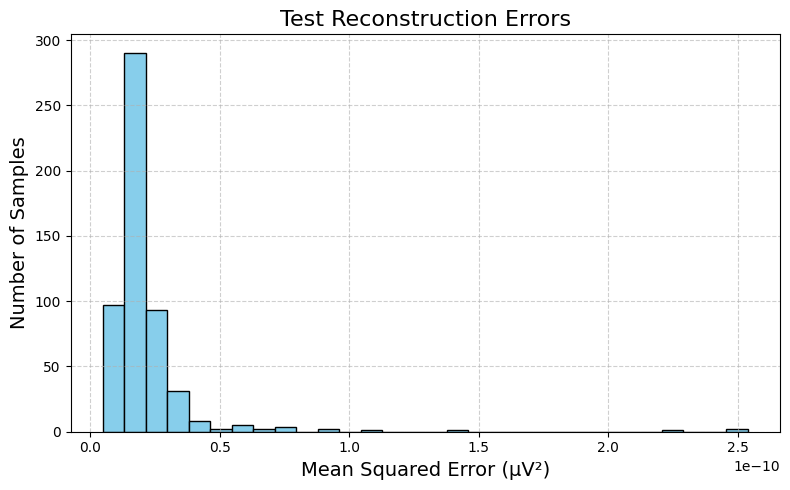

In [ ]:
# Compute reconstruction errors
reconstructed_norm = model.predict(test_signal_norm)
# If min-max:
reconstructions = (reconstructed_norm + 1) / 2 * (max_val - min_val) + min_val
errors = np.mean((test_signal - reconstructions)**2, axis=(1,2,3))

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title('Test Reconstruction Errors', fontsize=16)
plt.xlabel('Mean Squared Error (µV²)', fontsize=14)  # Add units
plt.ylabel('Number of Samples', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# raw is your original MNE Raw object
channel_names = ['O1', 'P7', 'P3', 'CP5', 'CP1', 'T7', 'C3', 'FC1', 'FC5', 'F3', 'F7', 'Fp1', 'O2', 'P8', 'P4', 'CP6', 'CP2', 'C4', 'T8', 'FC2', 'FC6', 'F4', 'F8', 'Fp2', 'Oz', 'Pz', 'CPz', 'Cz', 'FCz', 'AFz']
print(channel_names)
print(f"Number of channels: {len(channel_names)}")

['O1', 'P7', 'P3', 'CP5', 'CP1', 'T7', 'C3', 'FC1', 'FC5', 'F3', 'F7', 'Fp1', 'O2', 'P8', 'P4', 'CP6', 'CP2', 'C4', 'T8', 'FC2', 'FC6', 'F4', 'F8', 'Fp2', 'Oz', 'Pz', 'CPz', 'Cz', 'FCz', 'AFz']
Number of channels: 30


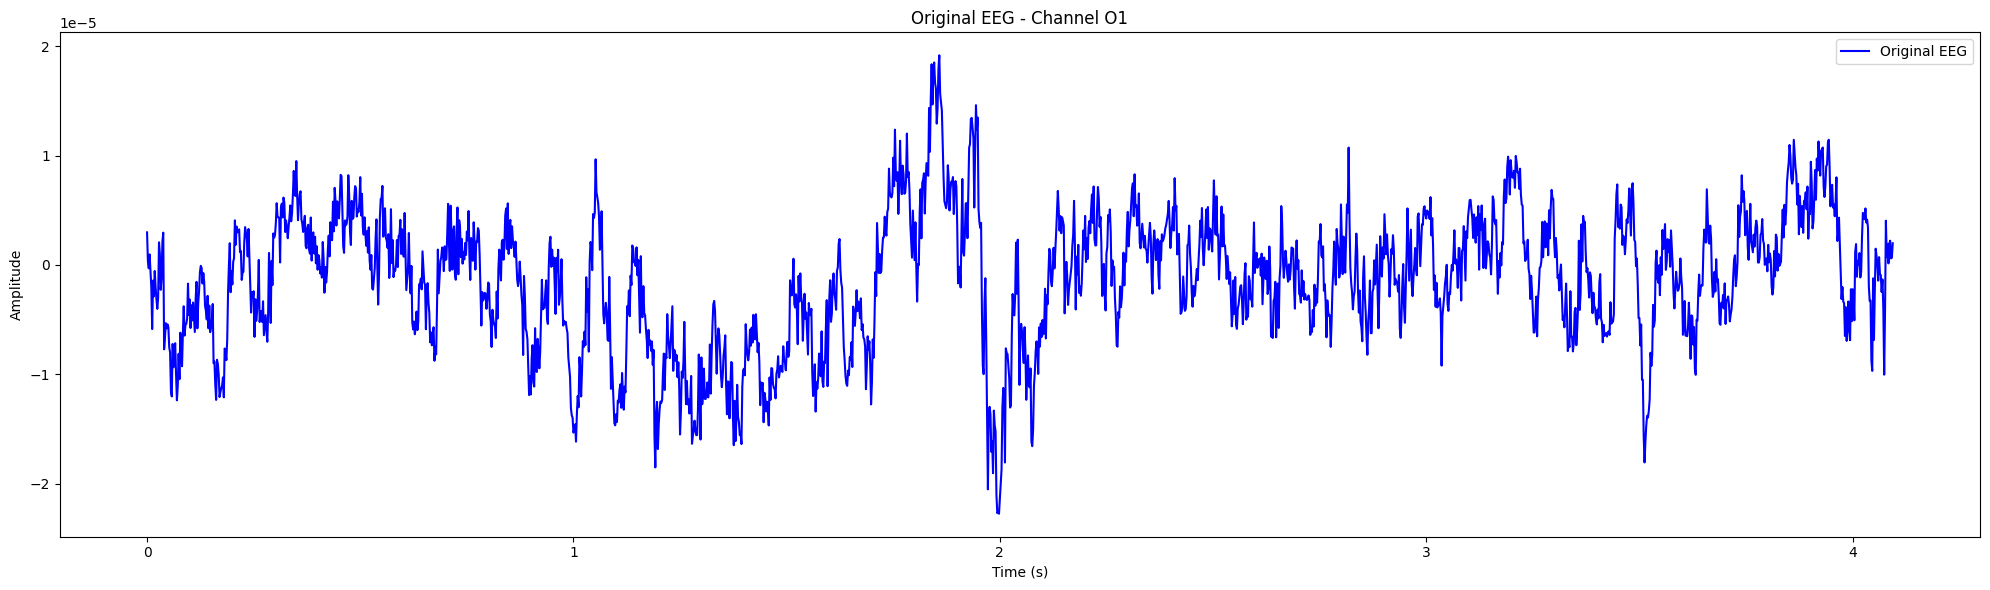

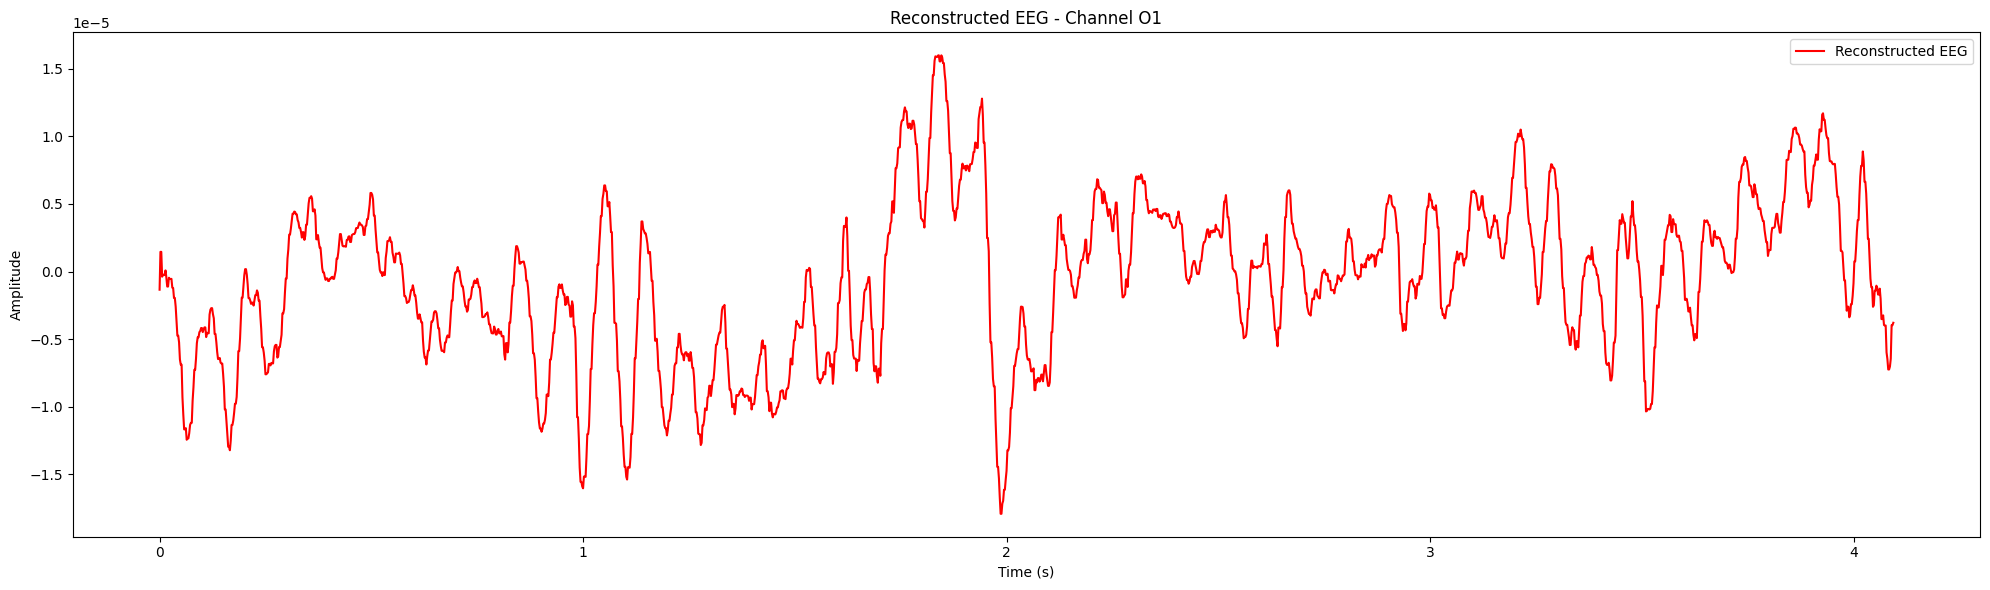

In [ ]:
# Select sample and channel
sample_idx = 0
channel_idx = 0  # 'O1'
channel_name = 'O1'

max_samples = SONG_LENGTH  # match your EEG length
time = np.arange(max_samples) / 500  # convert to seconds

# Extract signals
original = test_signal[sample_idx, channel_idx, :max_samples, 0]
reconstructed = reconstructions[sample_idx, channel_idx, :max_samples, 0]

# --- Plot Original EEG ---
plt.figure(figsize=(20,6))
plt.plot(time, original, label='Original EEG', color='blue')
plt.title(f'Original EEG - Channel {channel_name}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Reconstructed EEG ---
plt.figure(figsize=(20,6))
plt.plot(time, reconstructed, label='Reconstructed EEG', color='red')
plt.title(f'Reconstructed EEG - Channel {channel_name}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

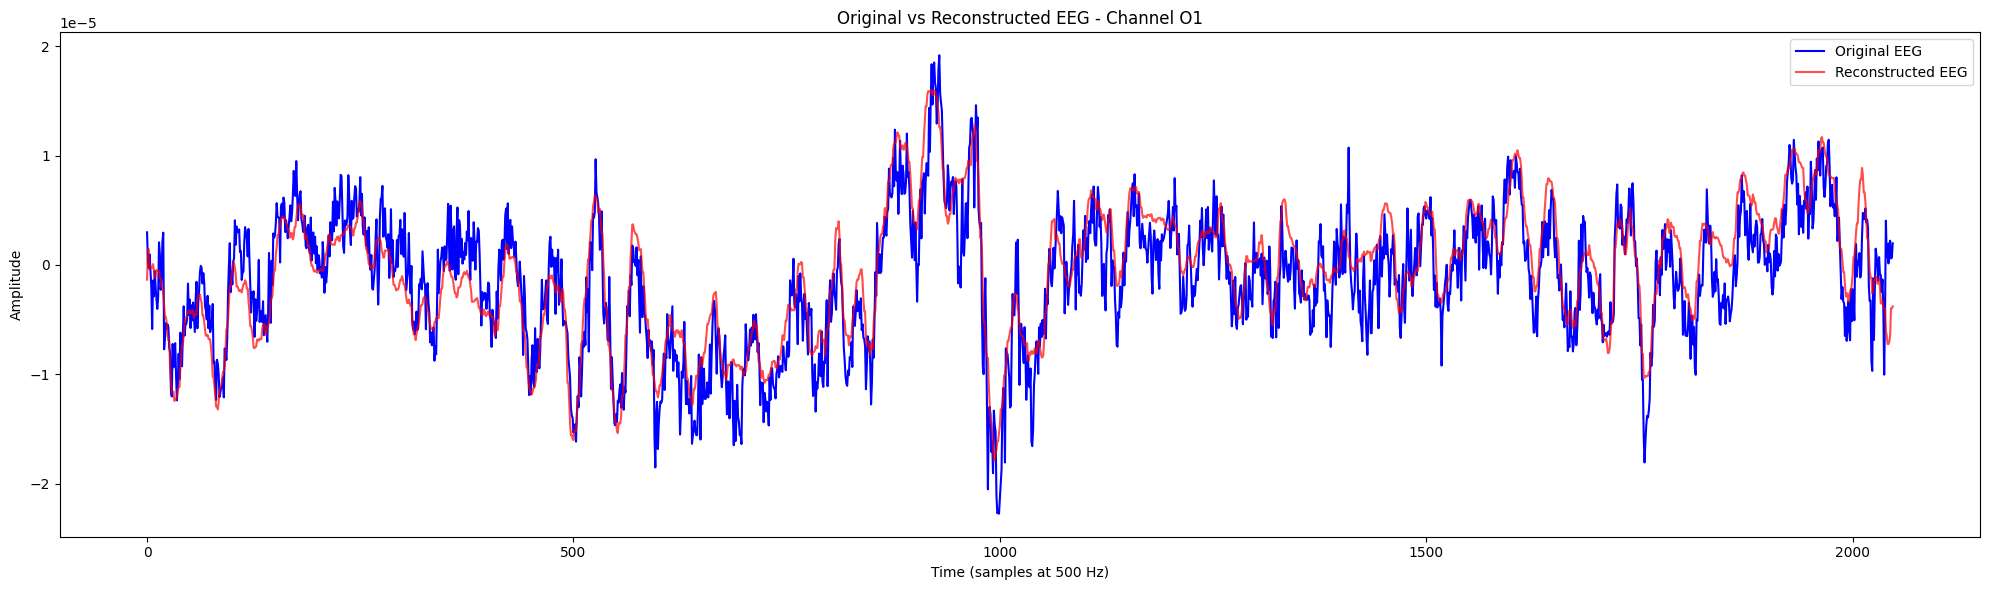

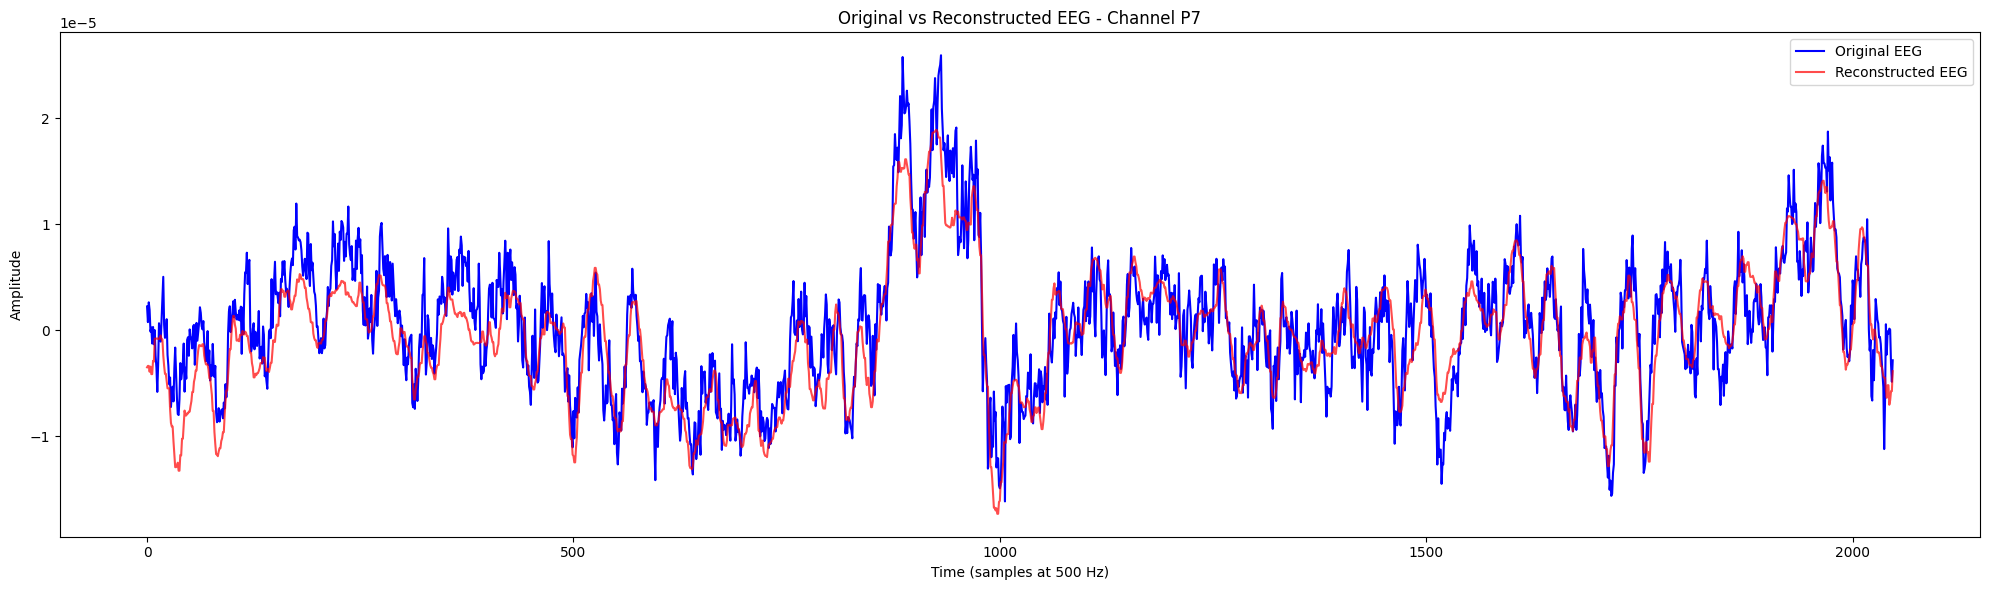

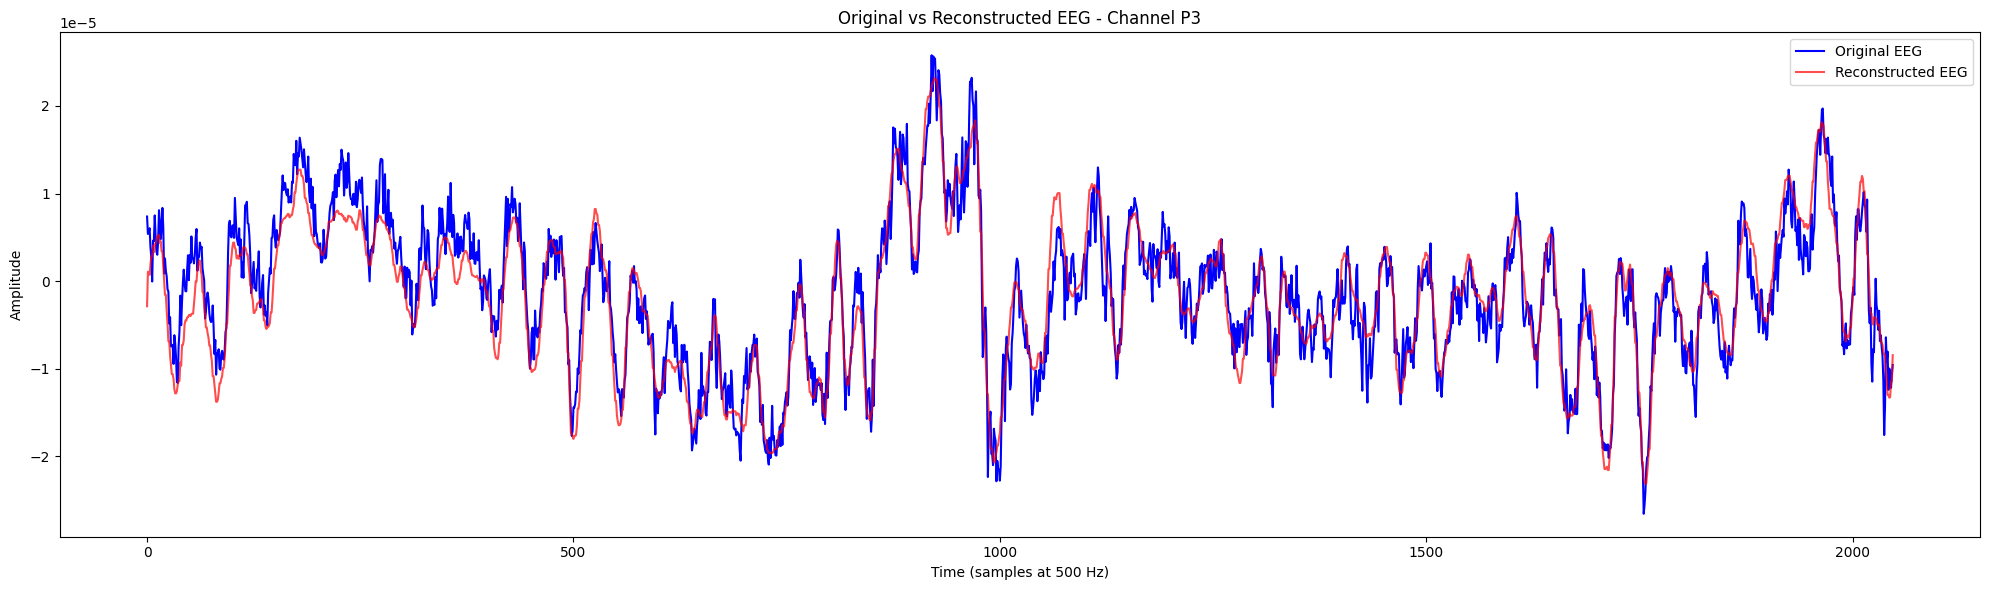

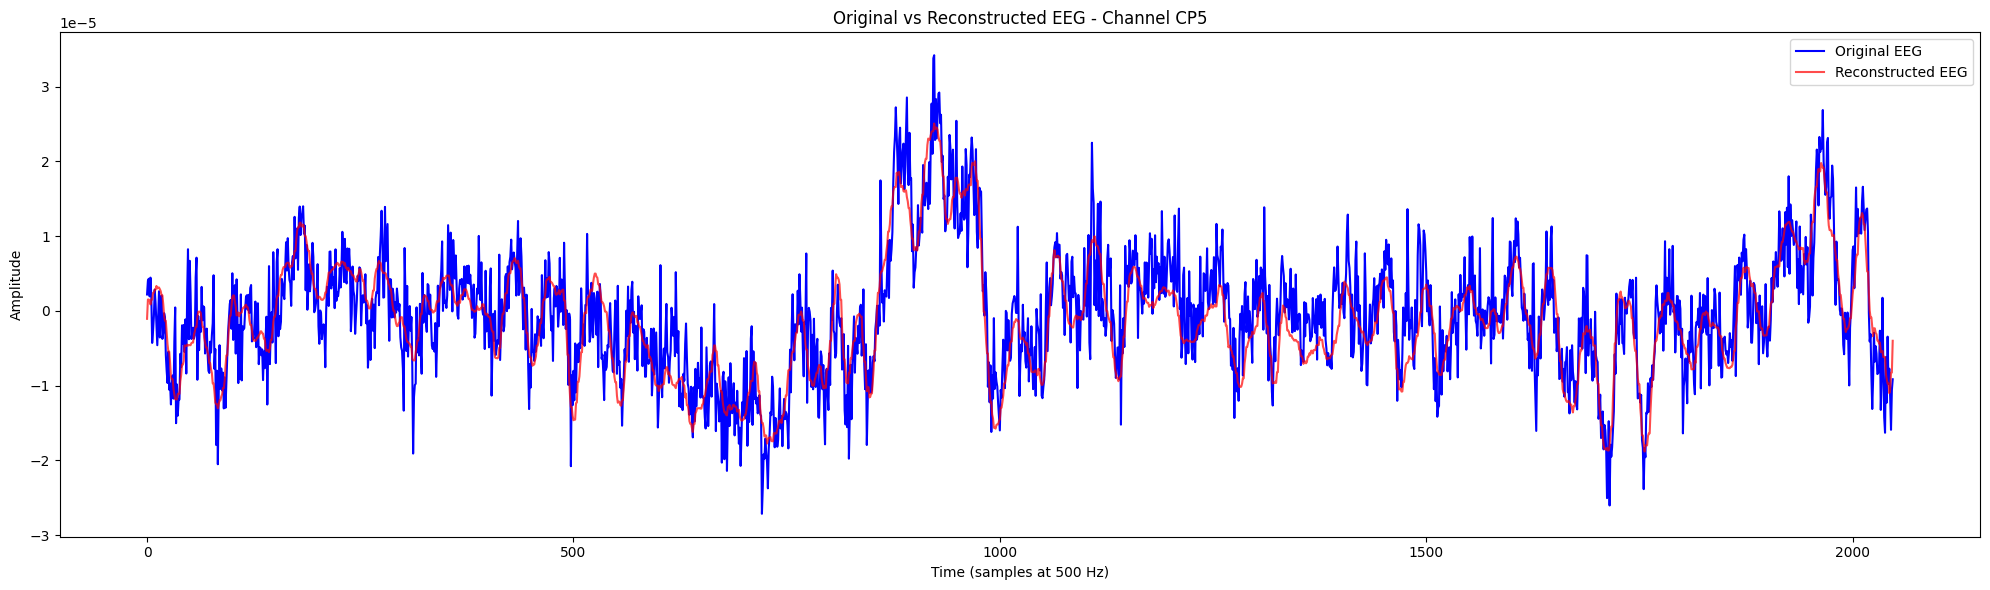

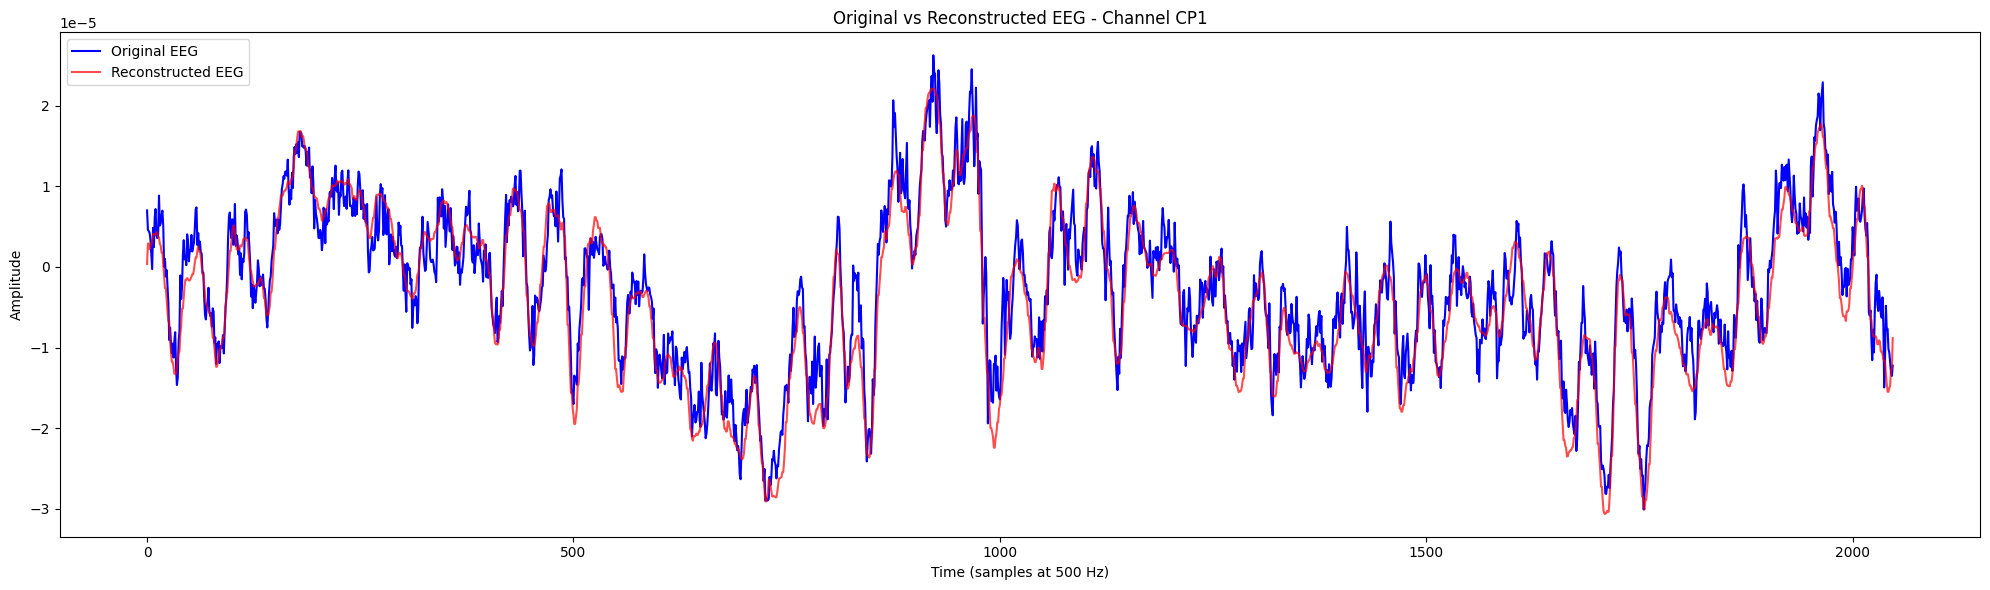

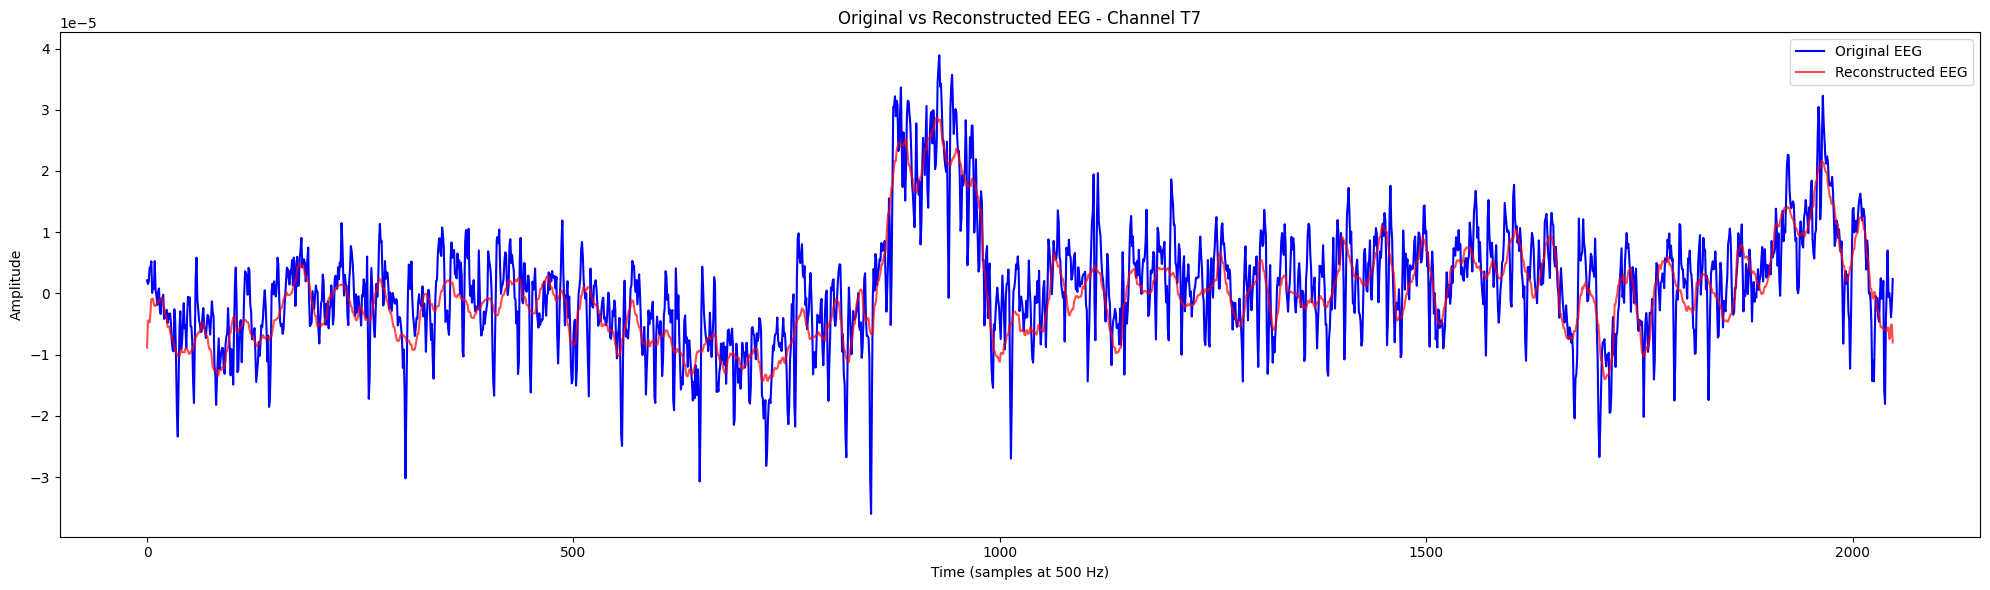

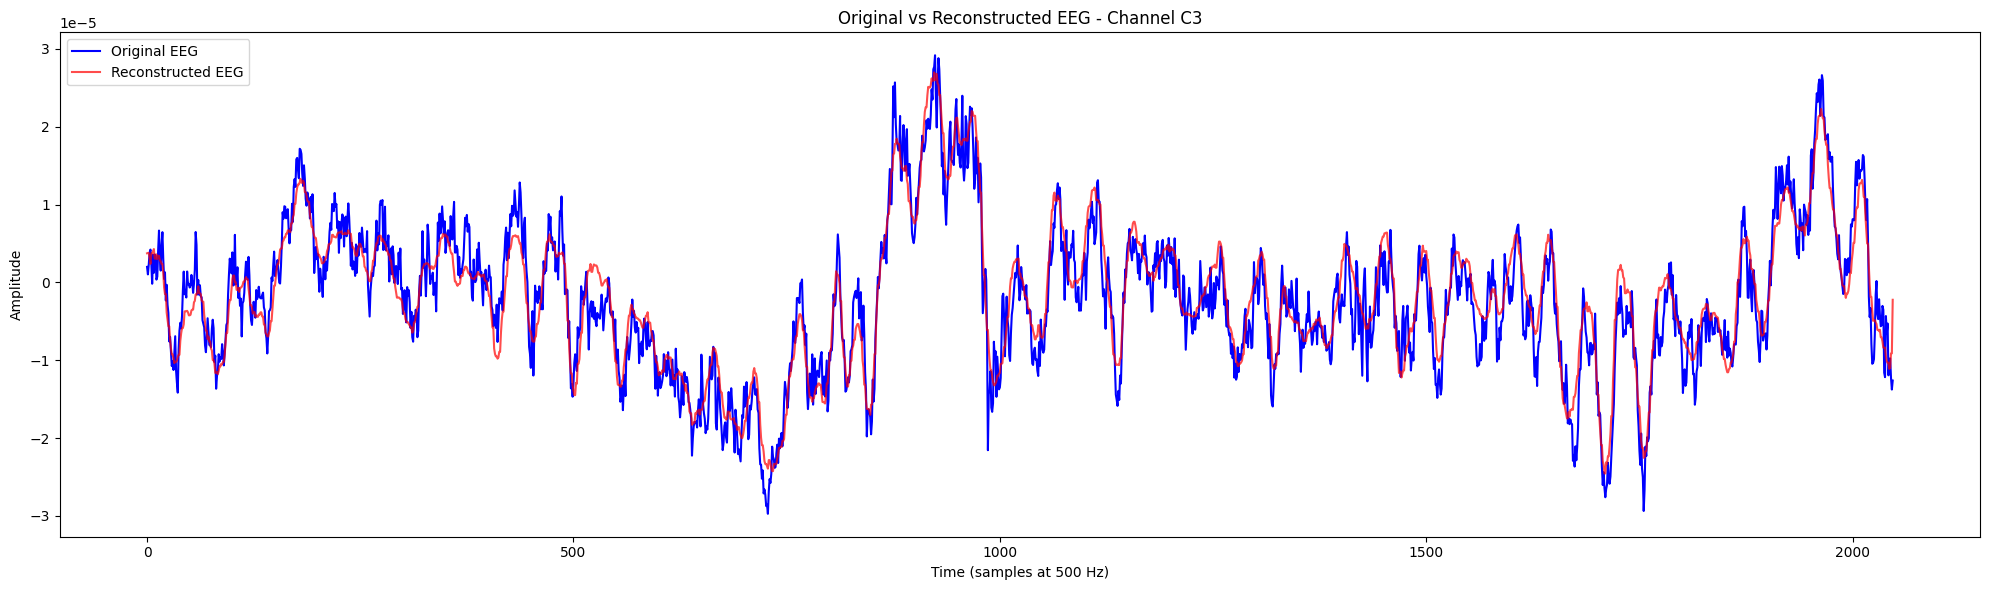

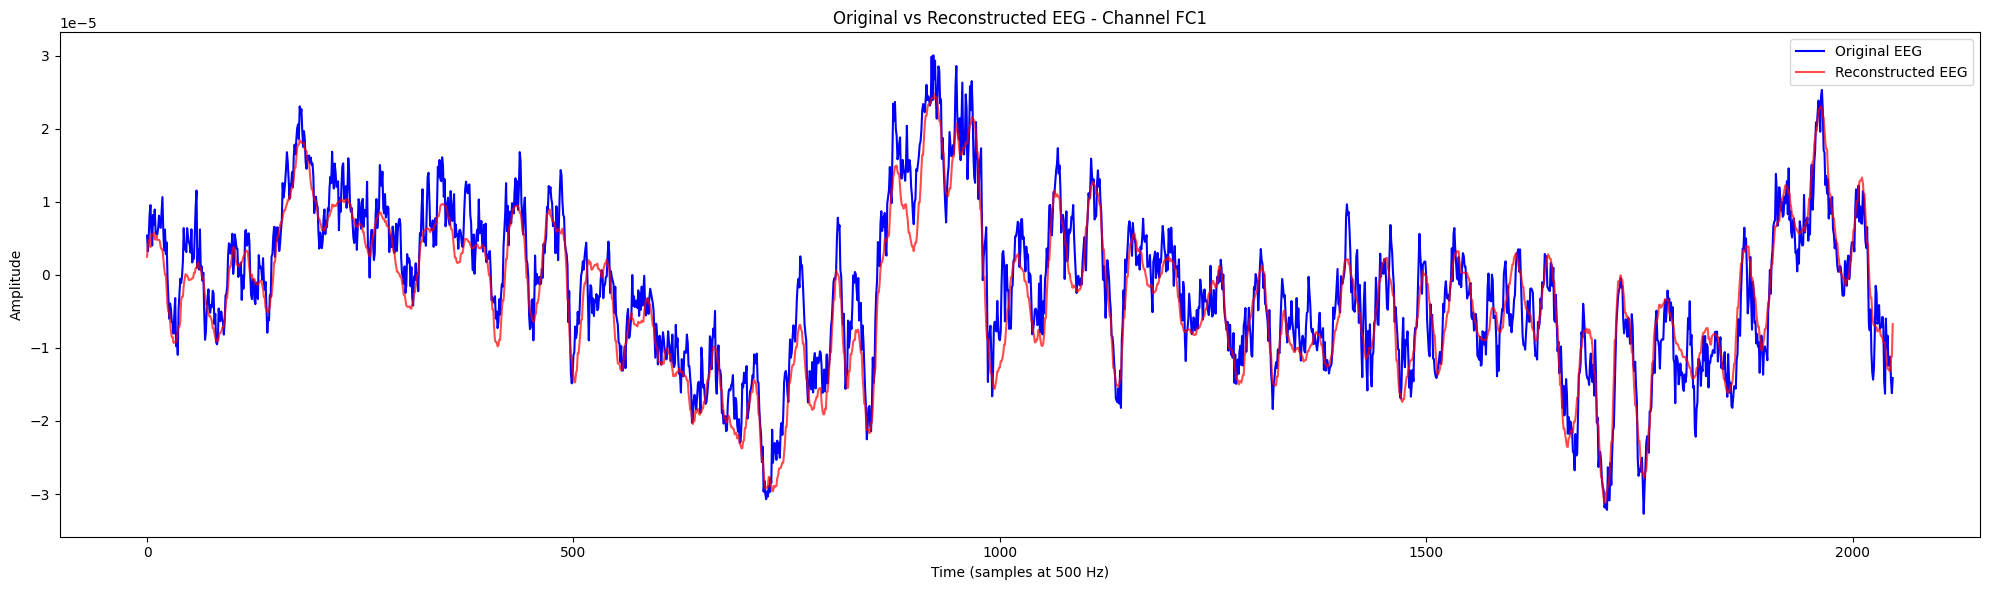

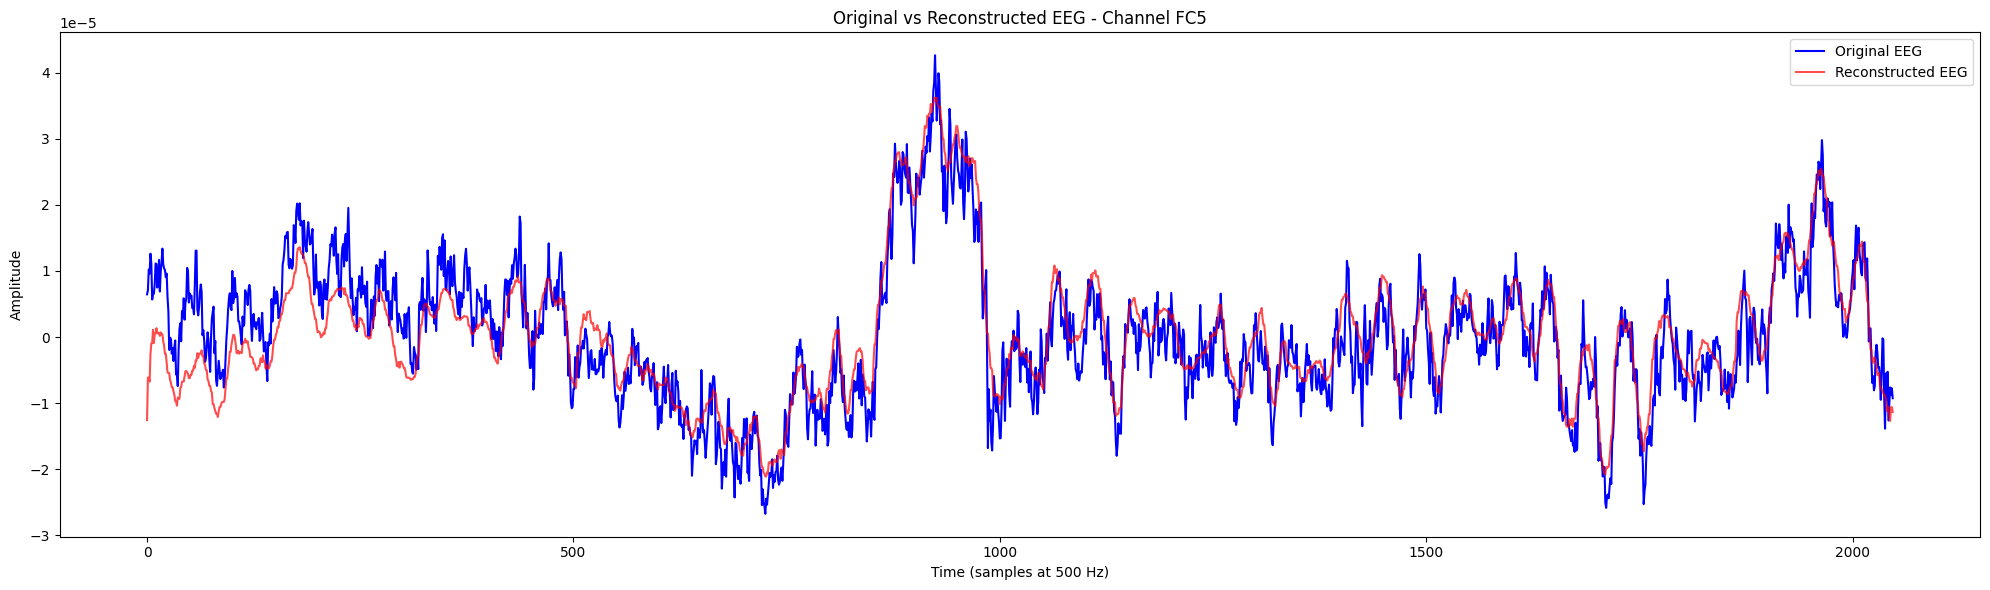

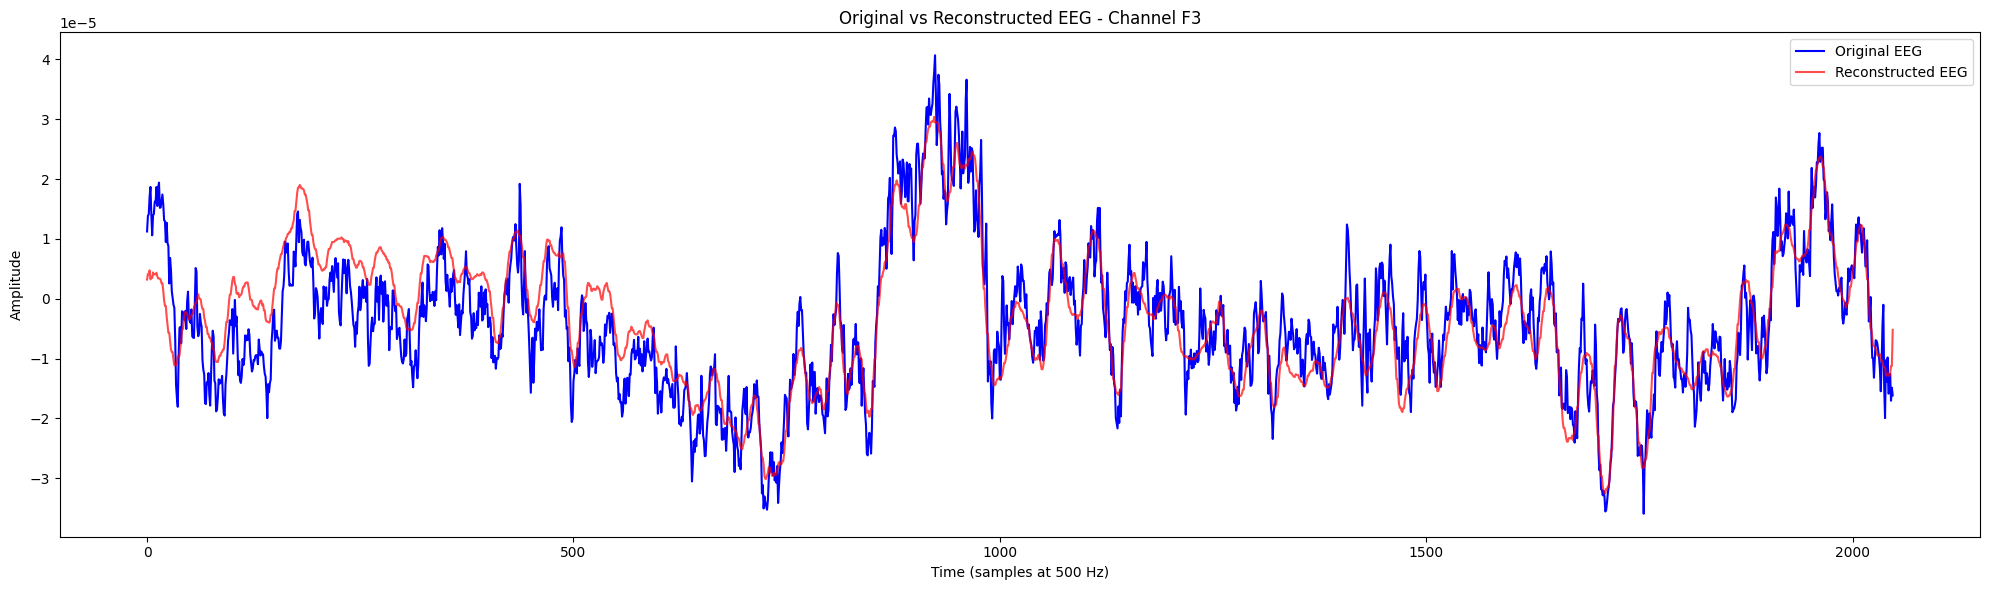

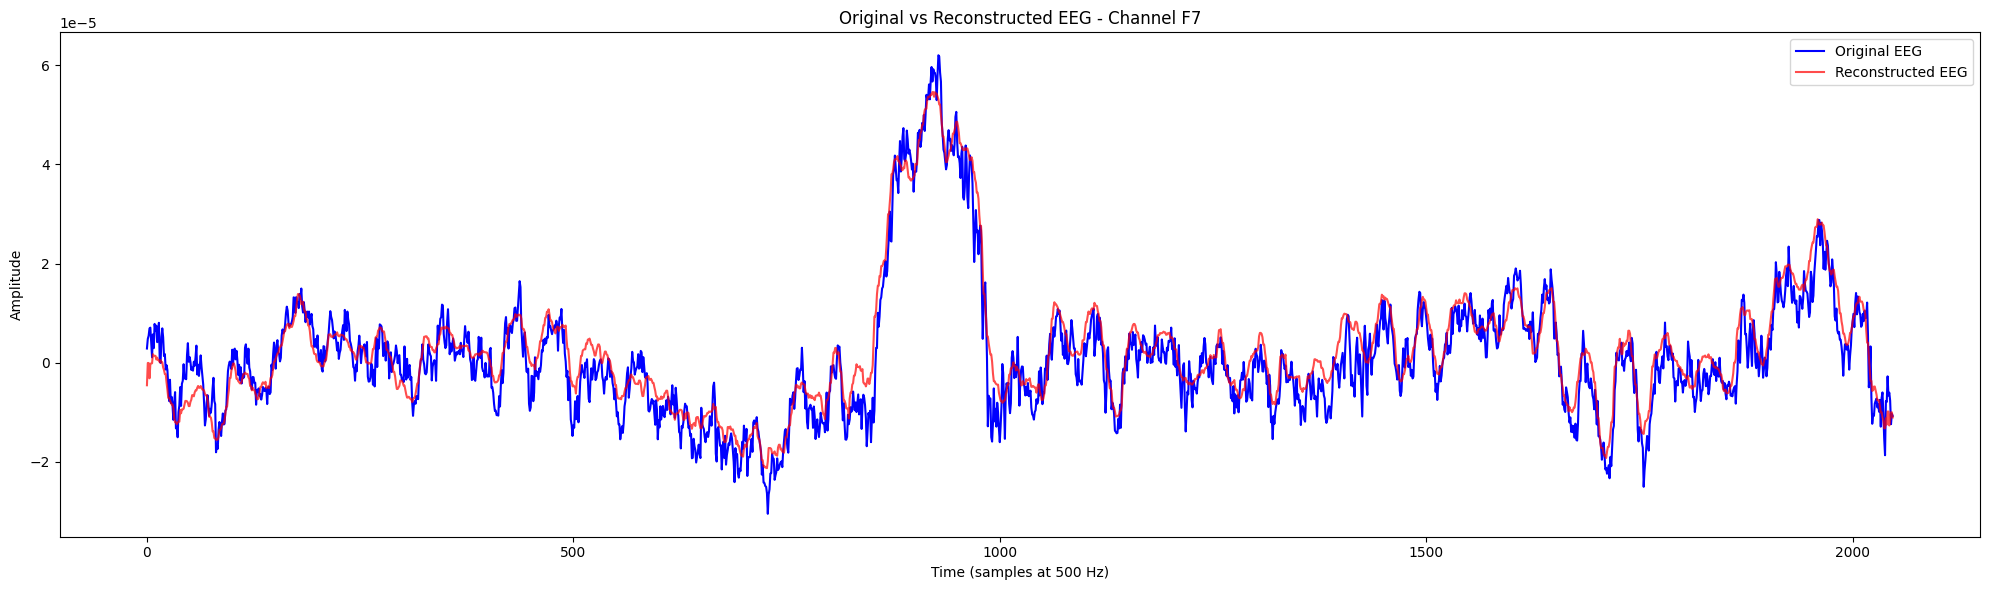

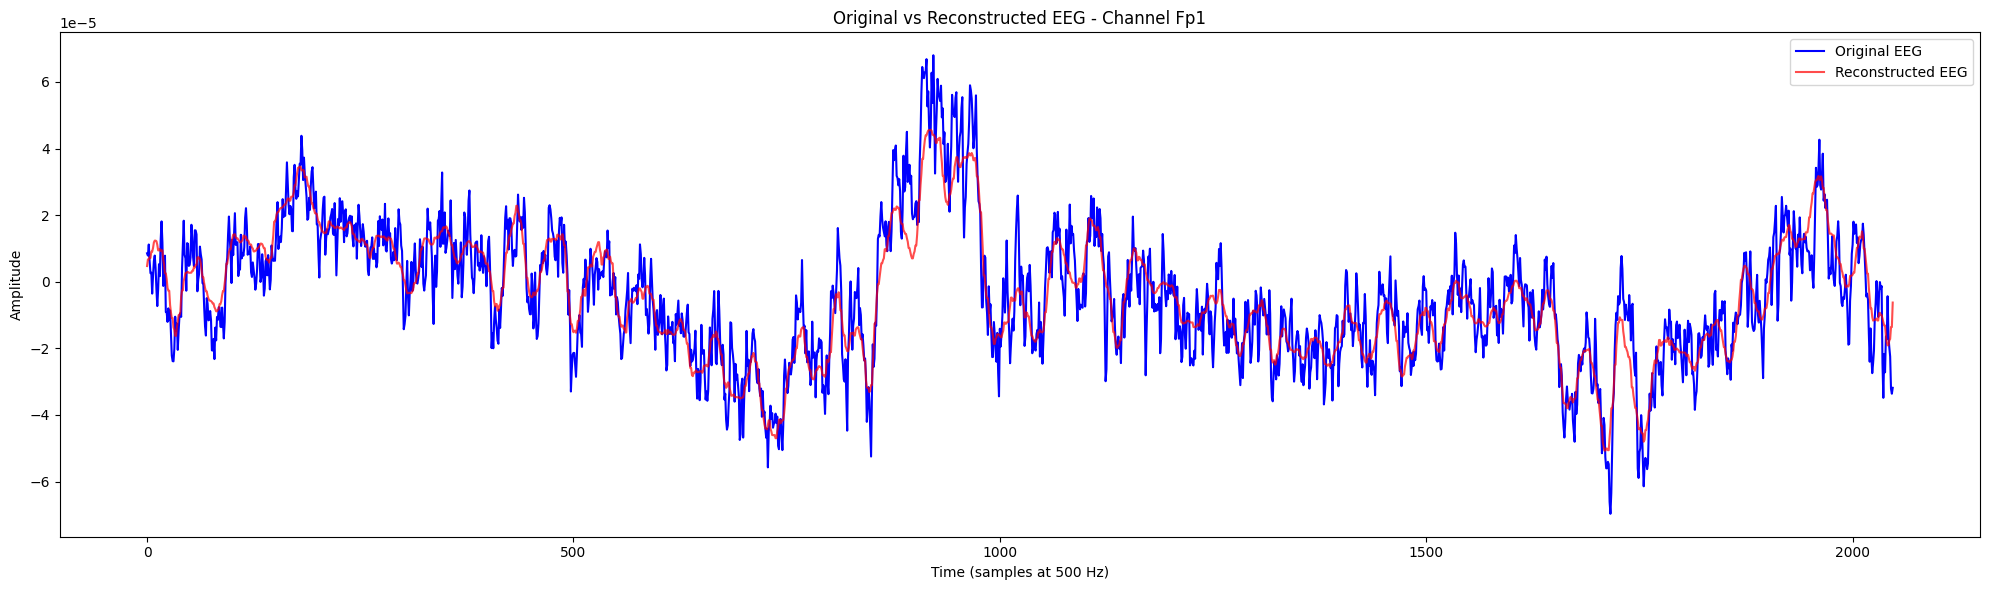

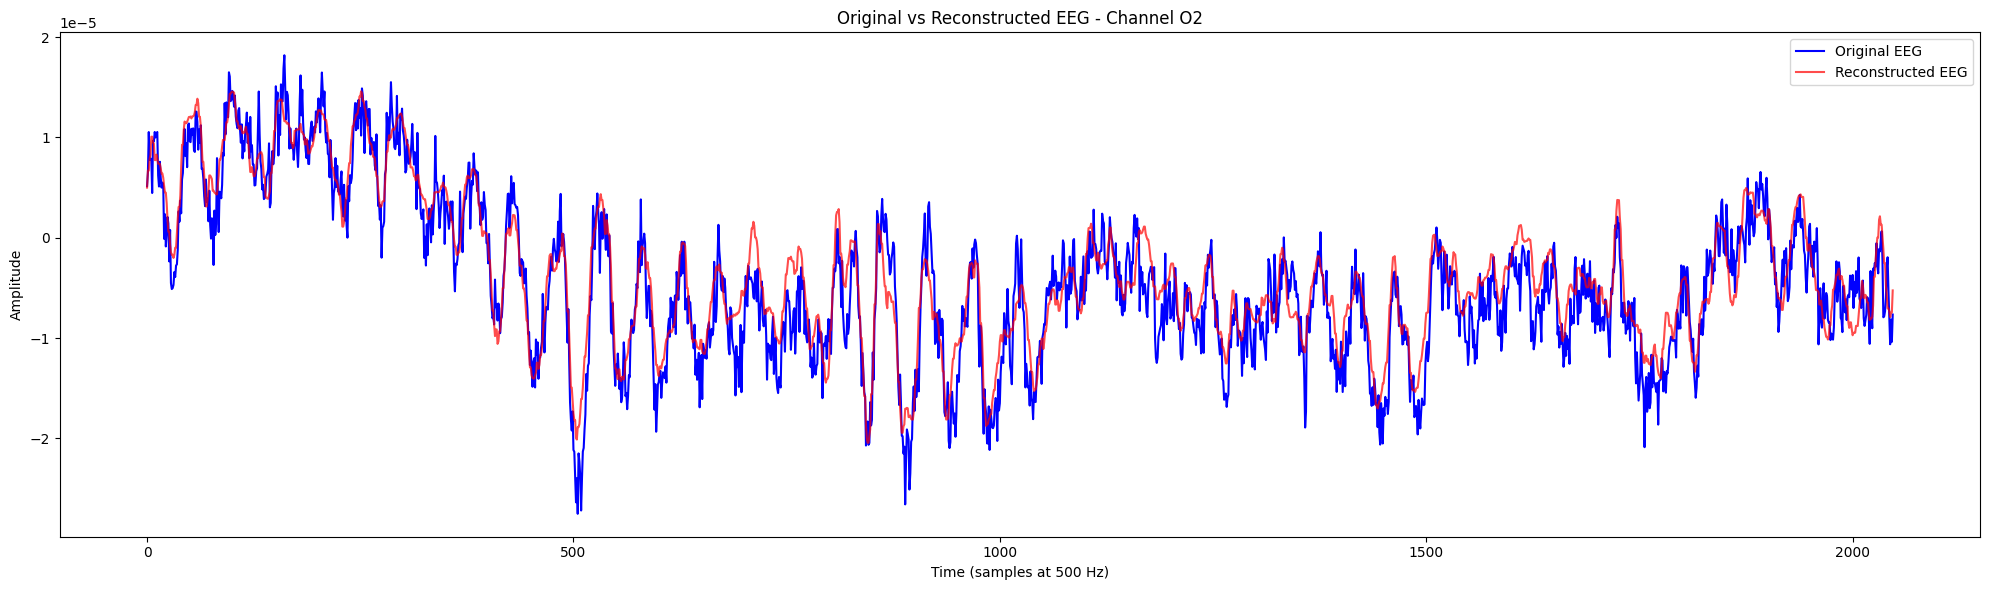

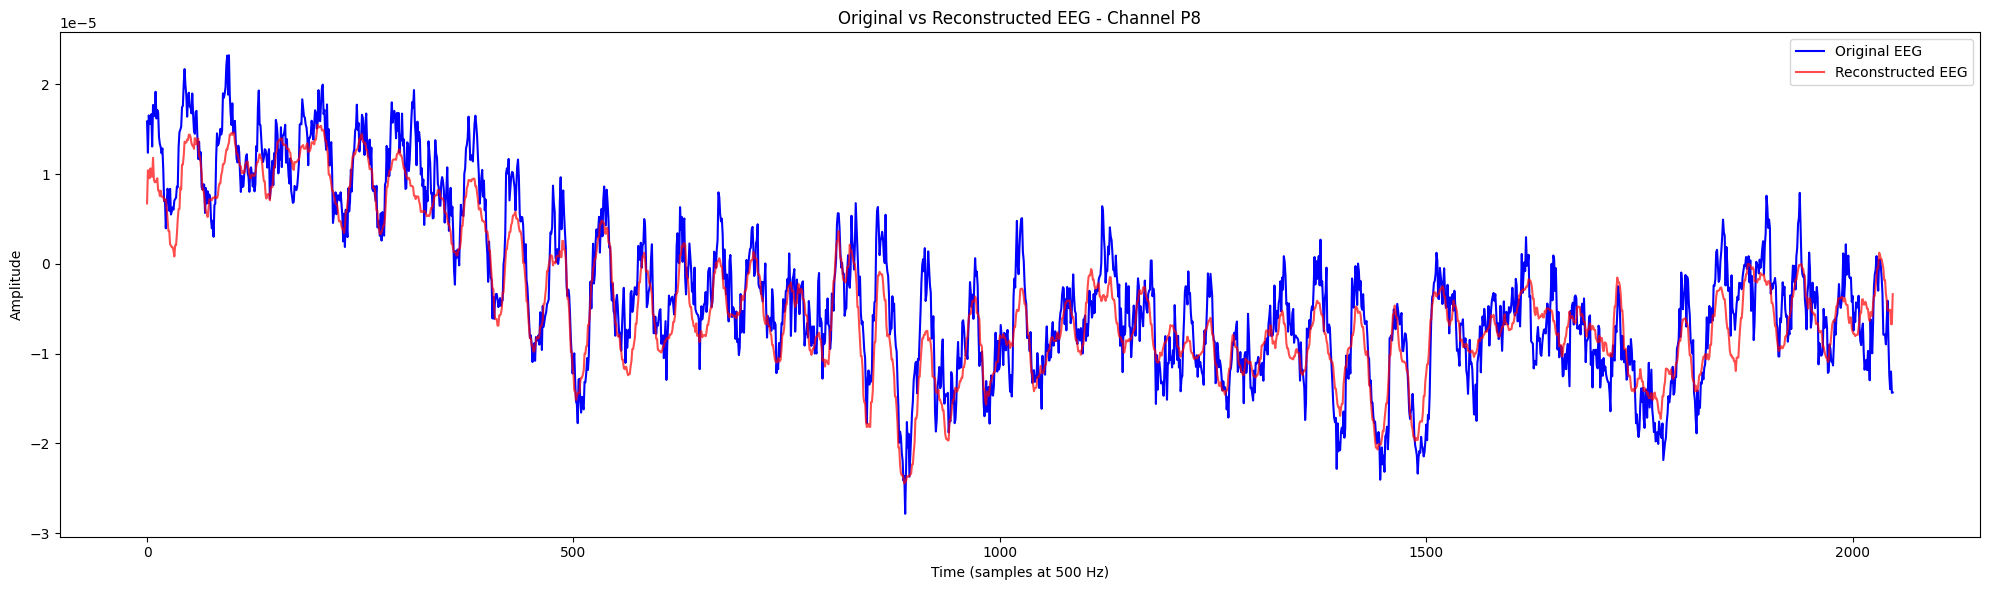

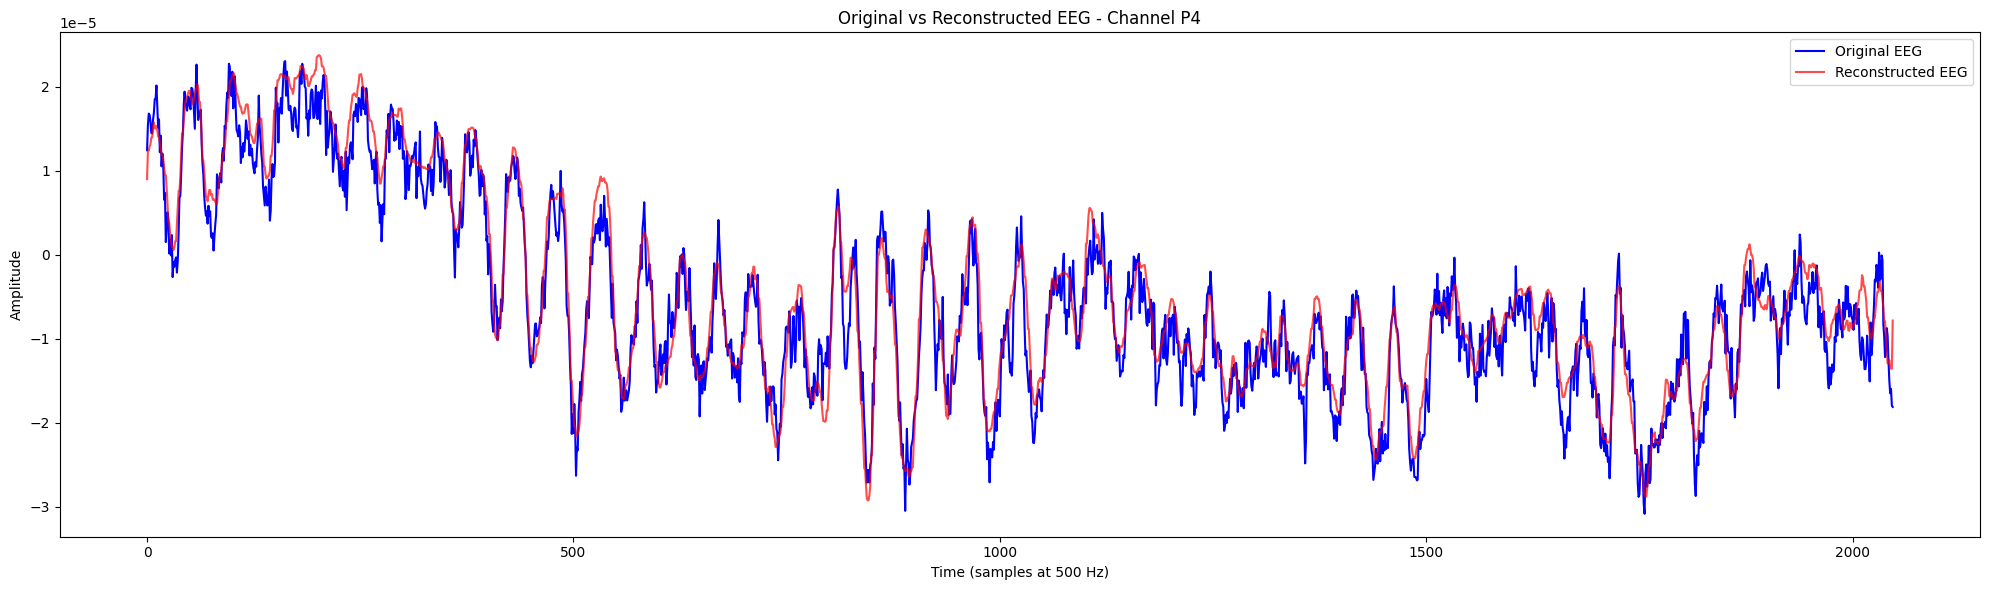

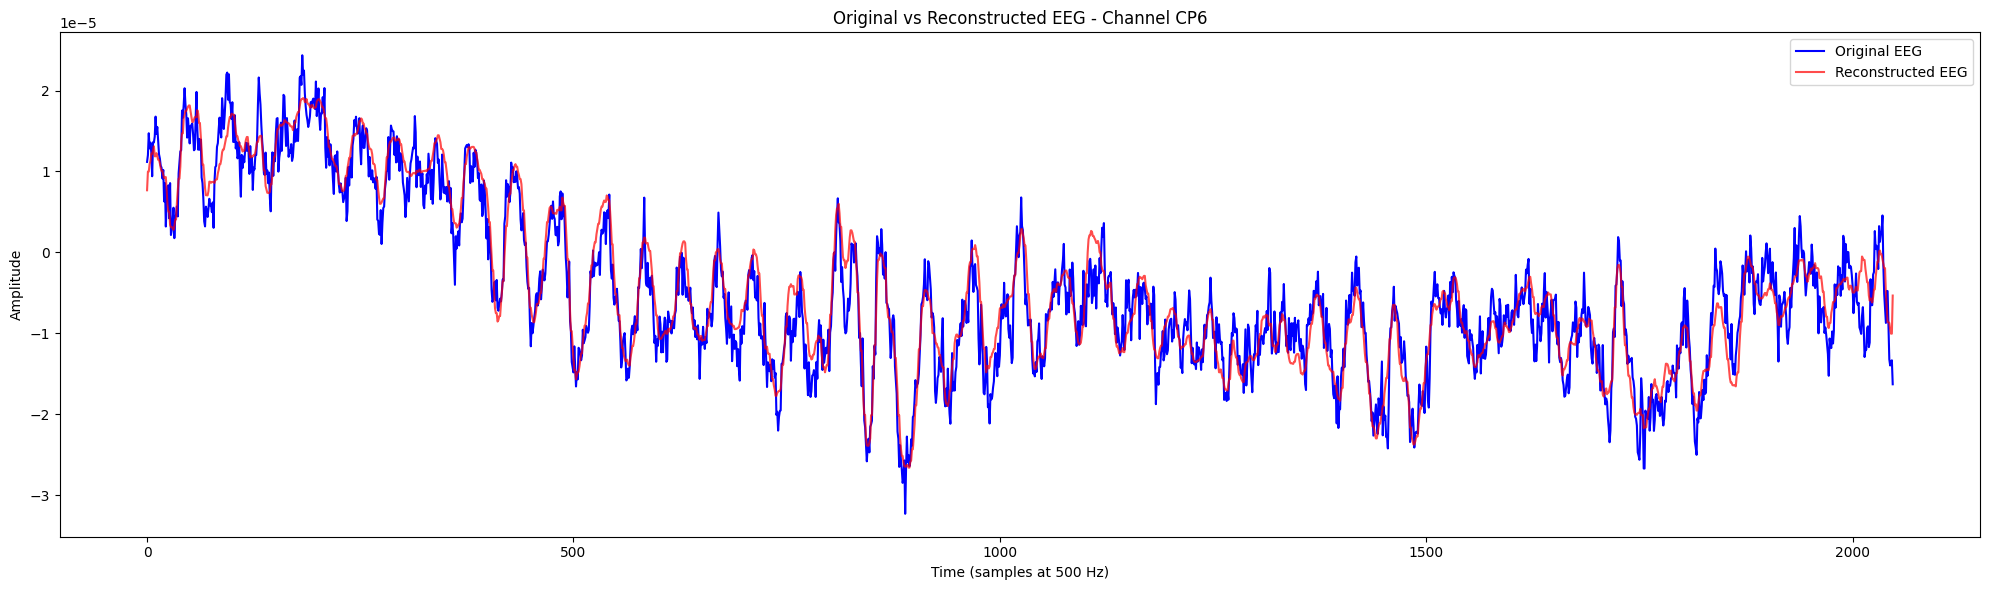

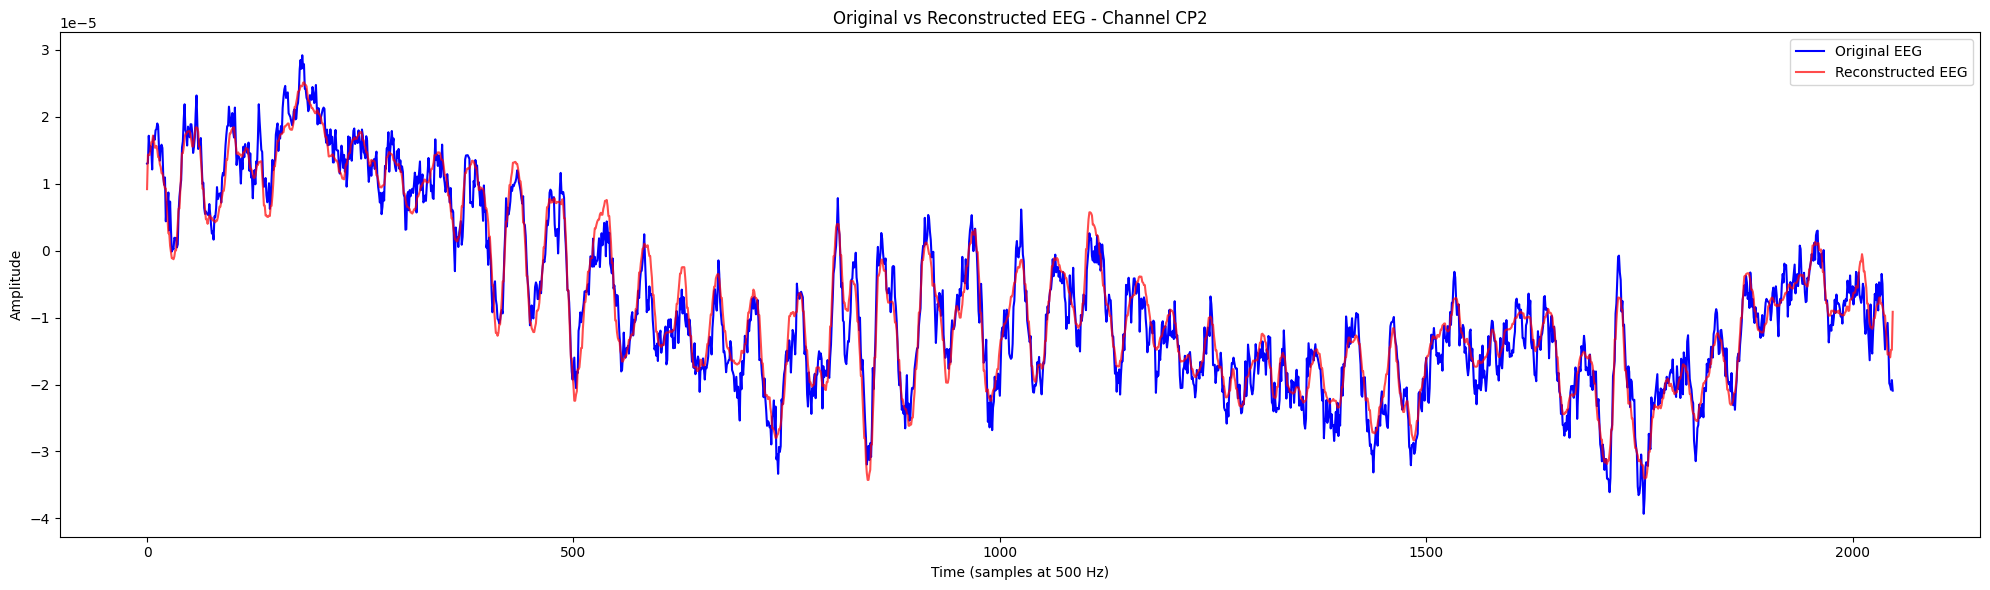

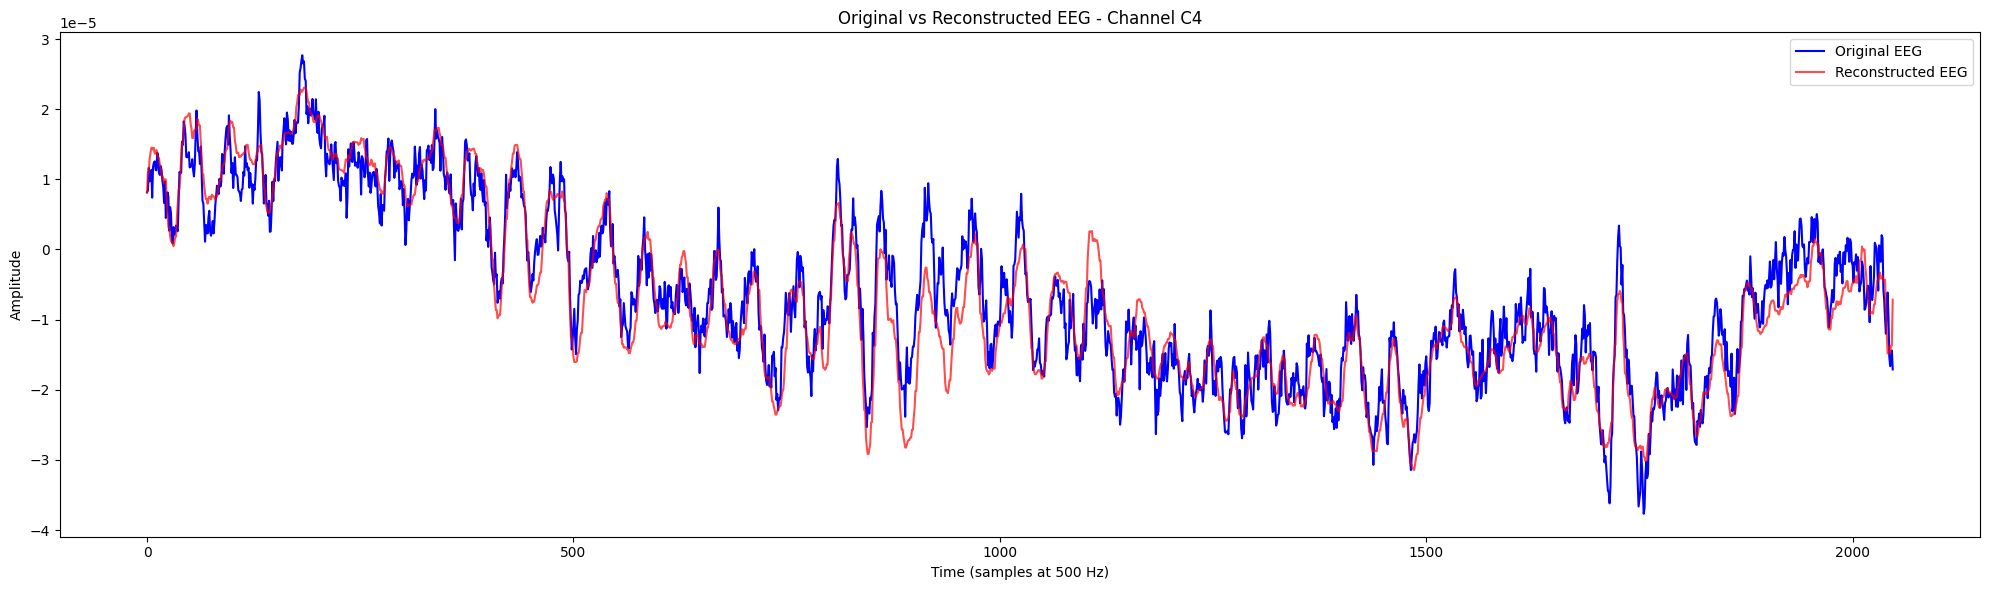

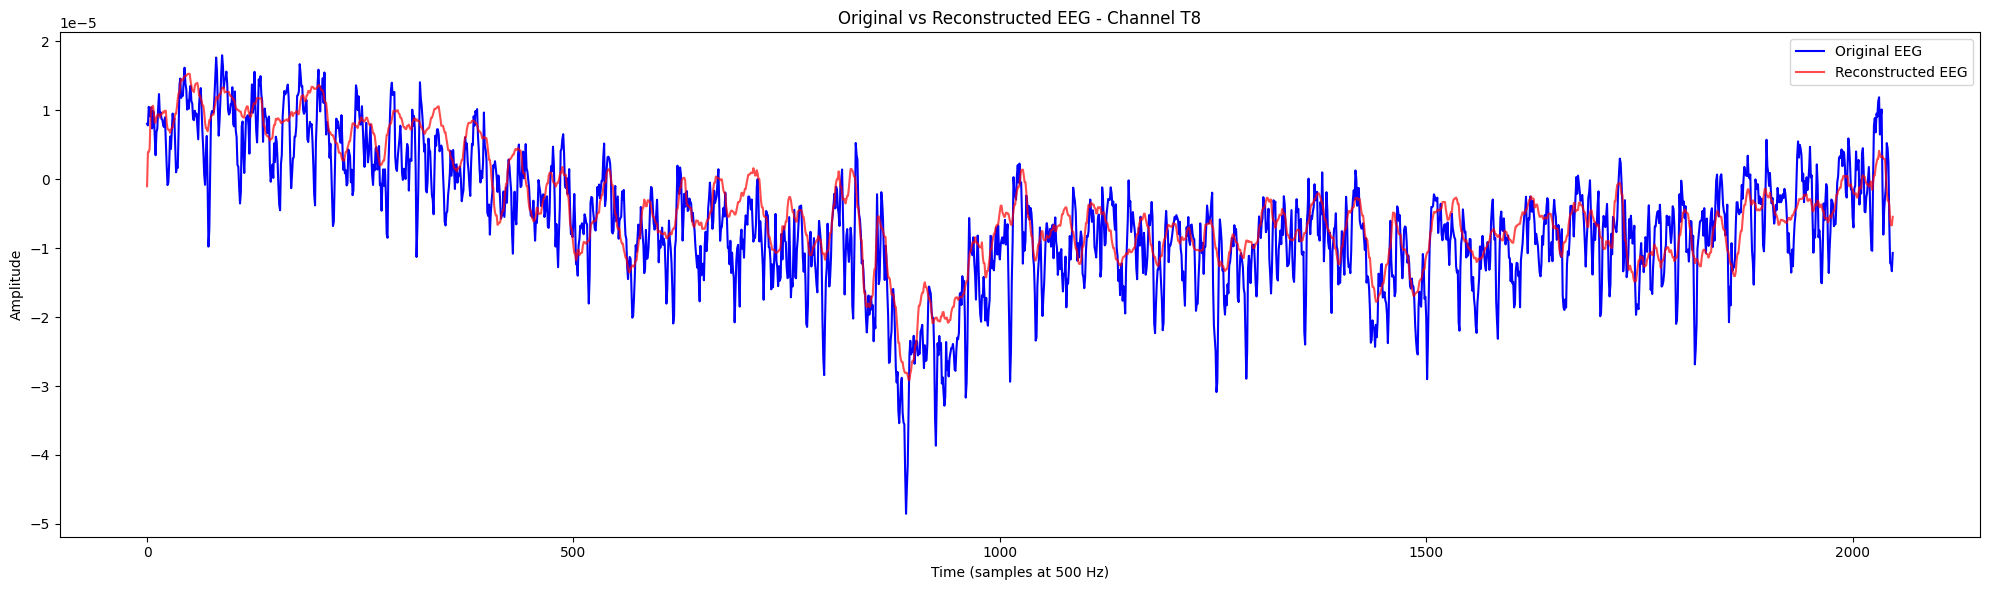

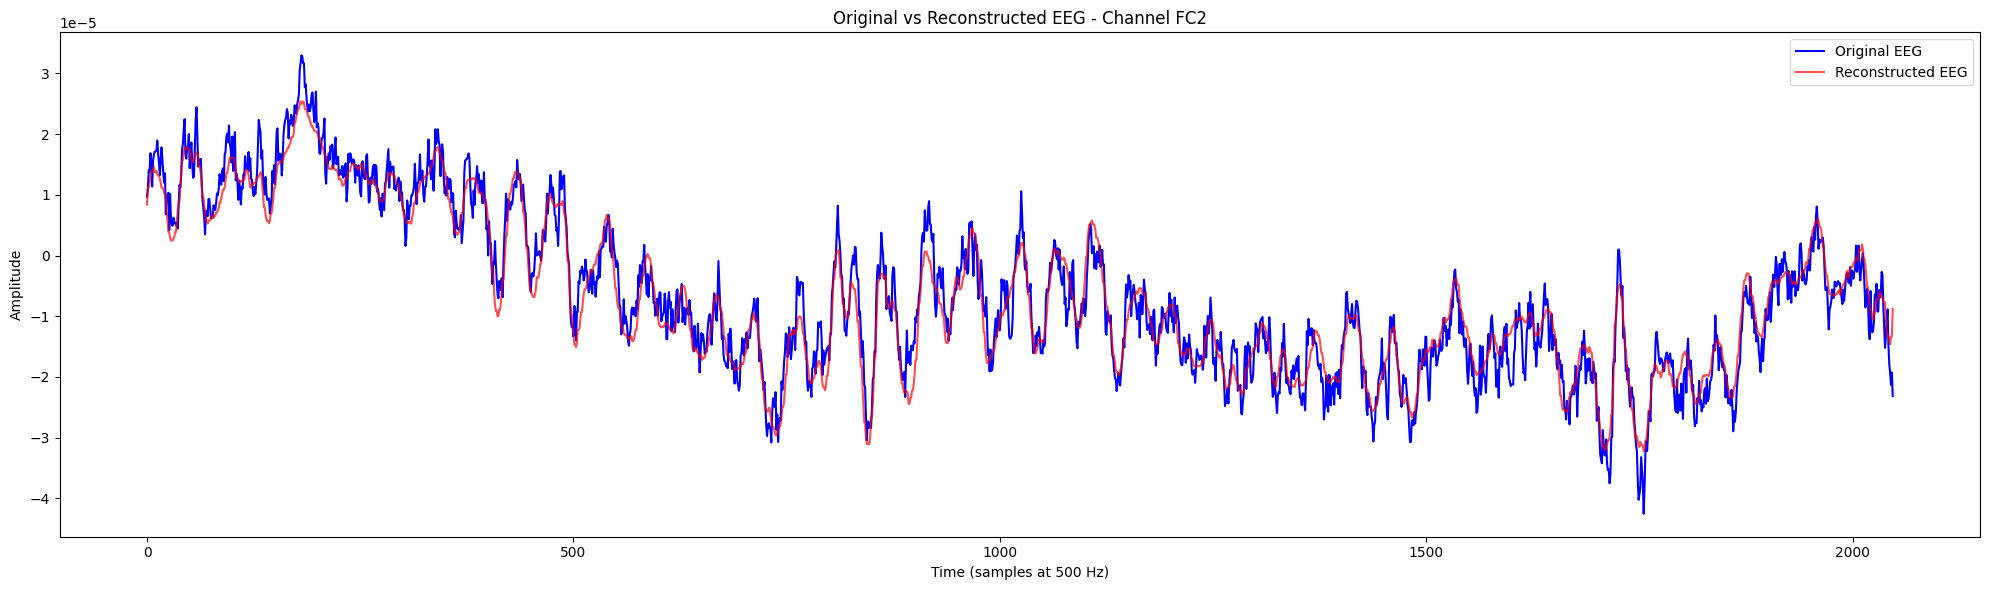

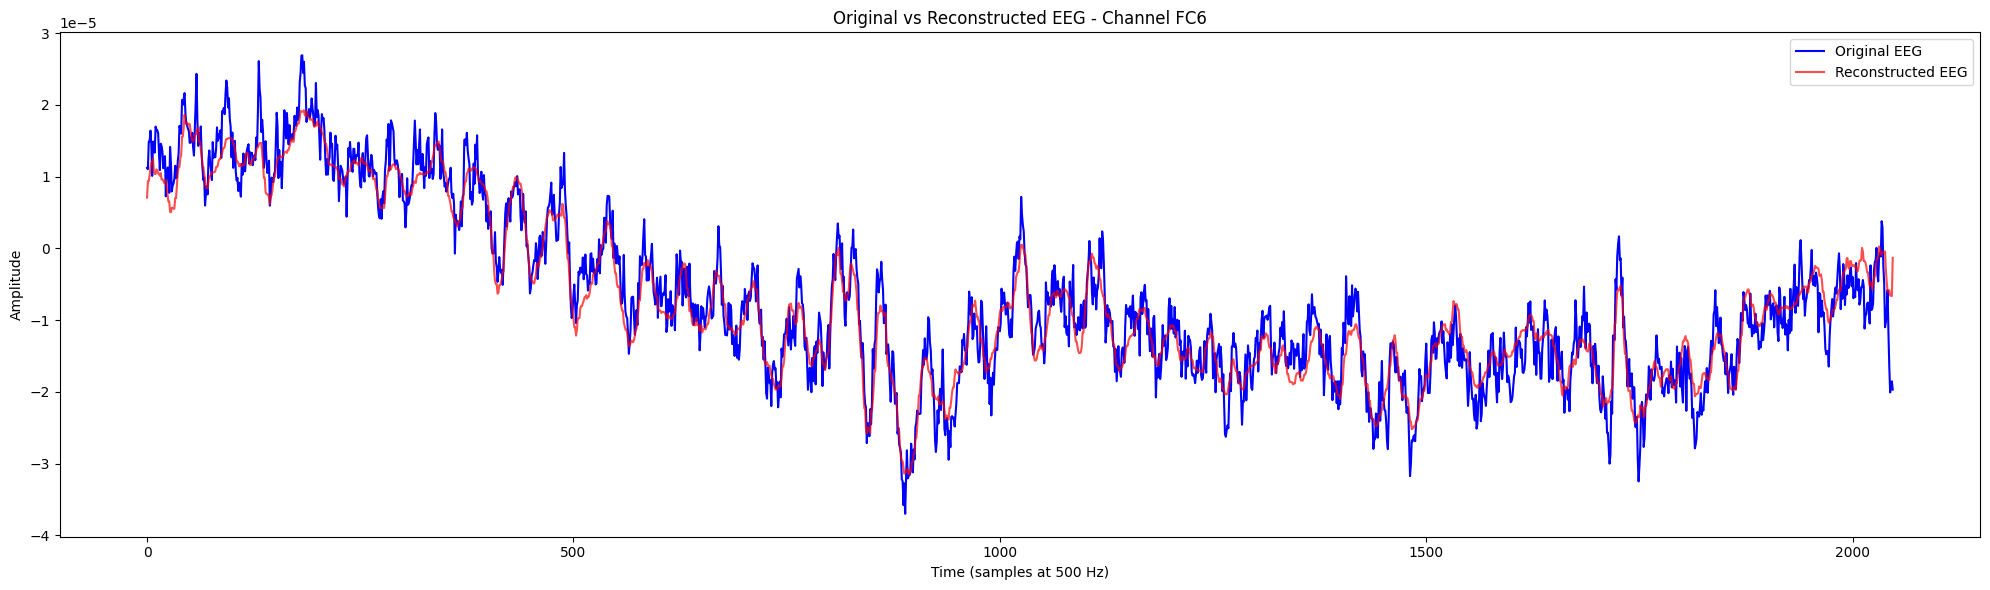

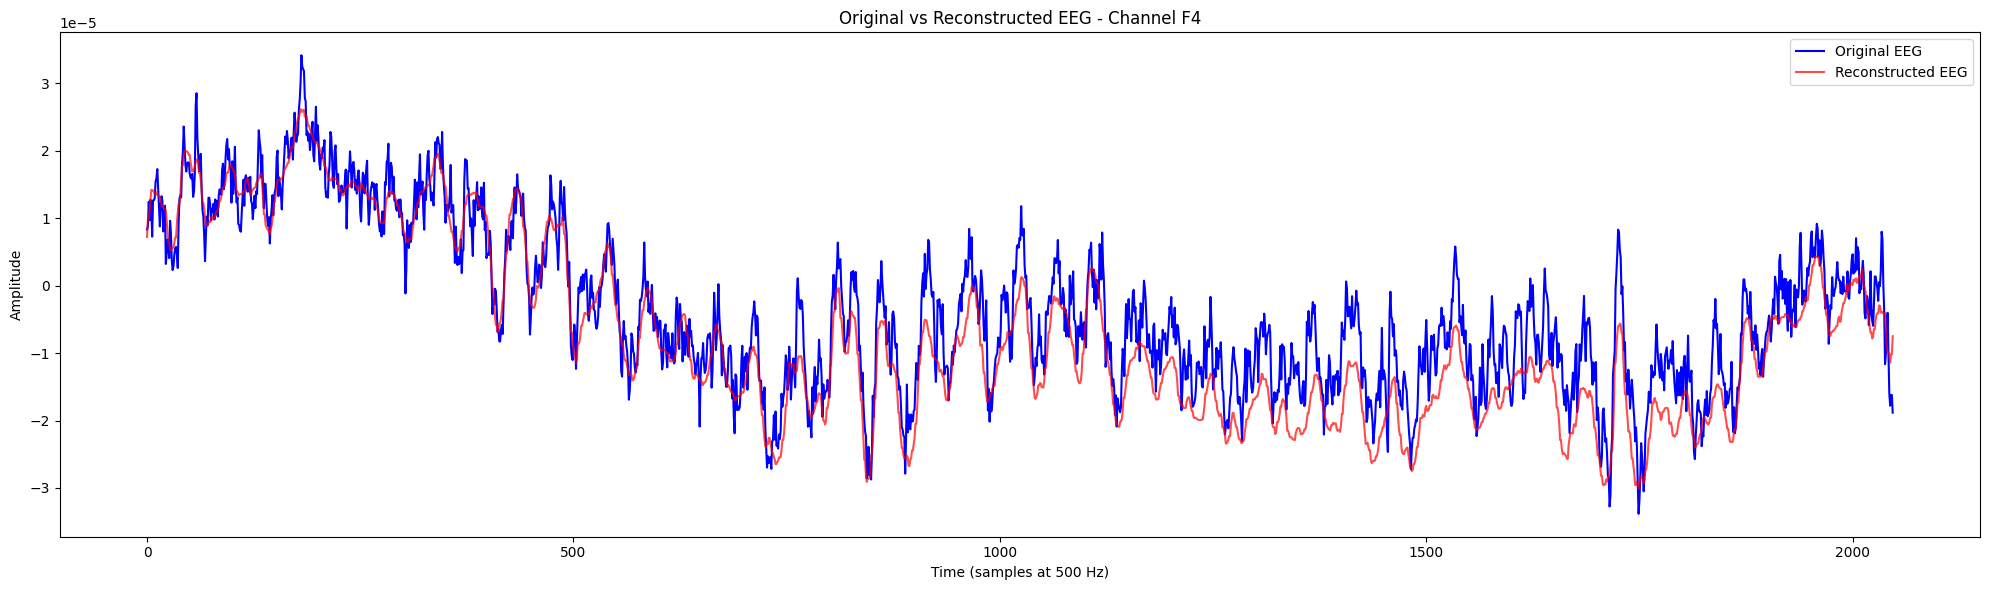

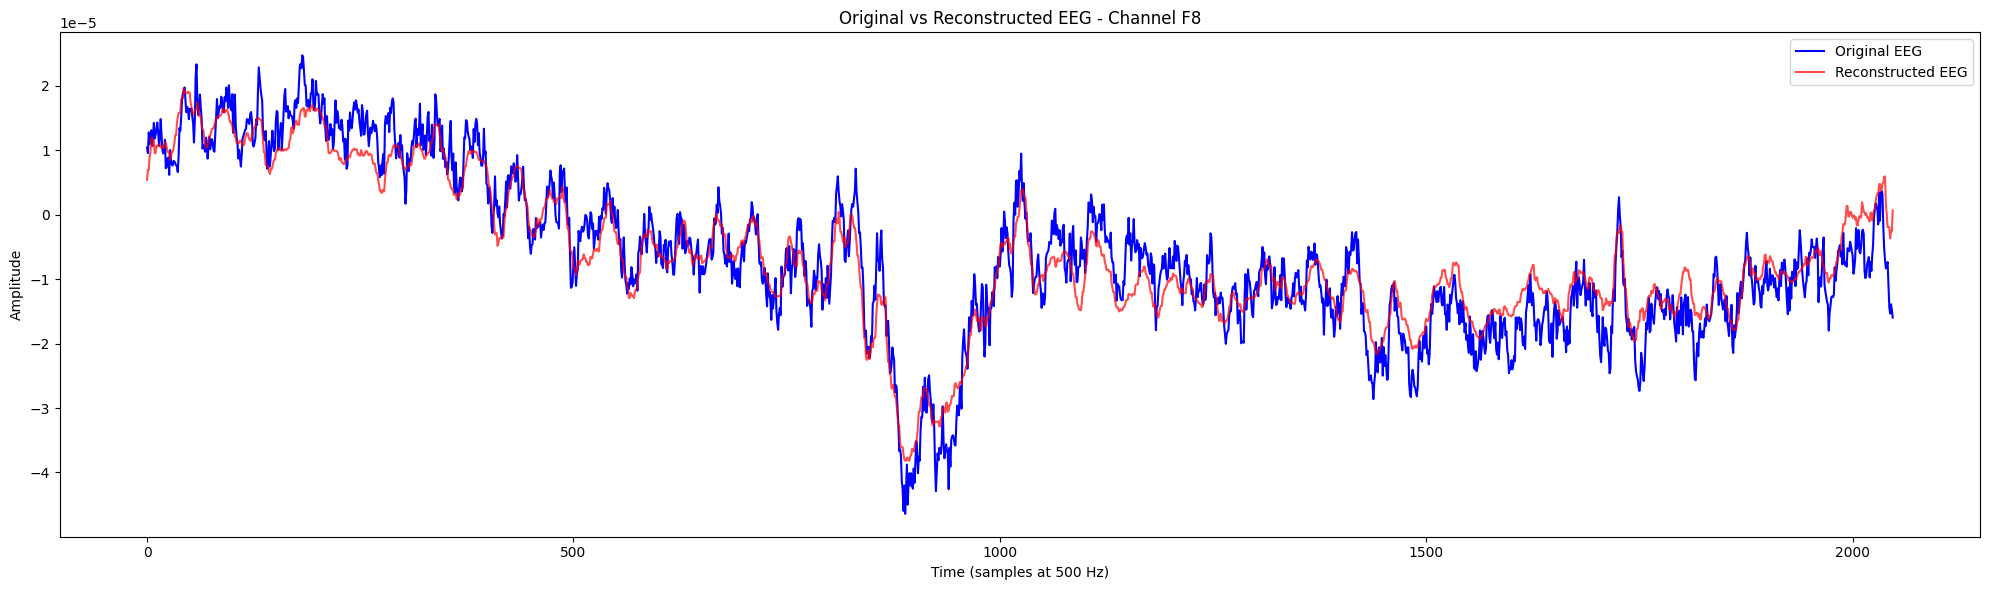

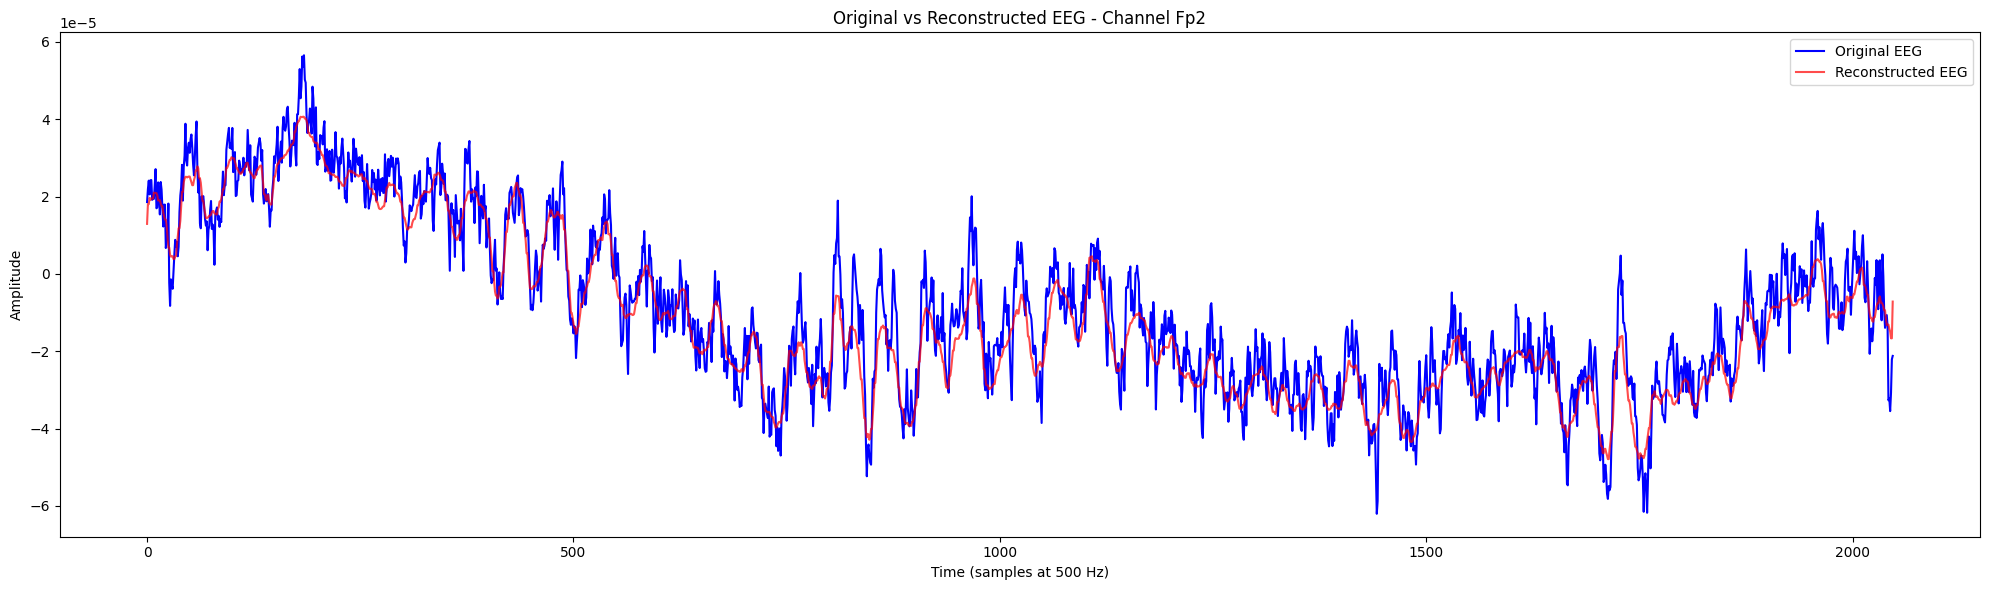

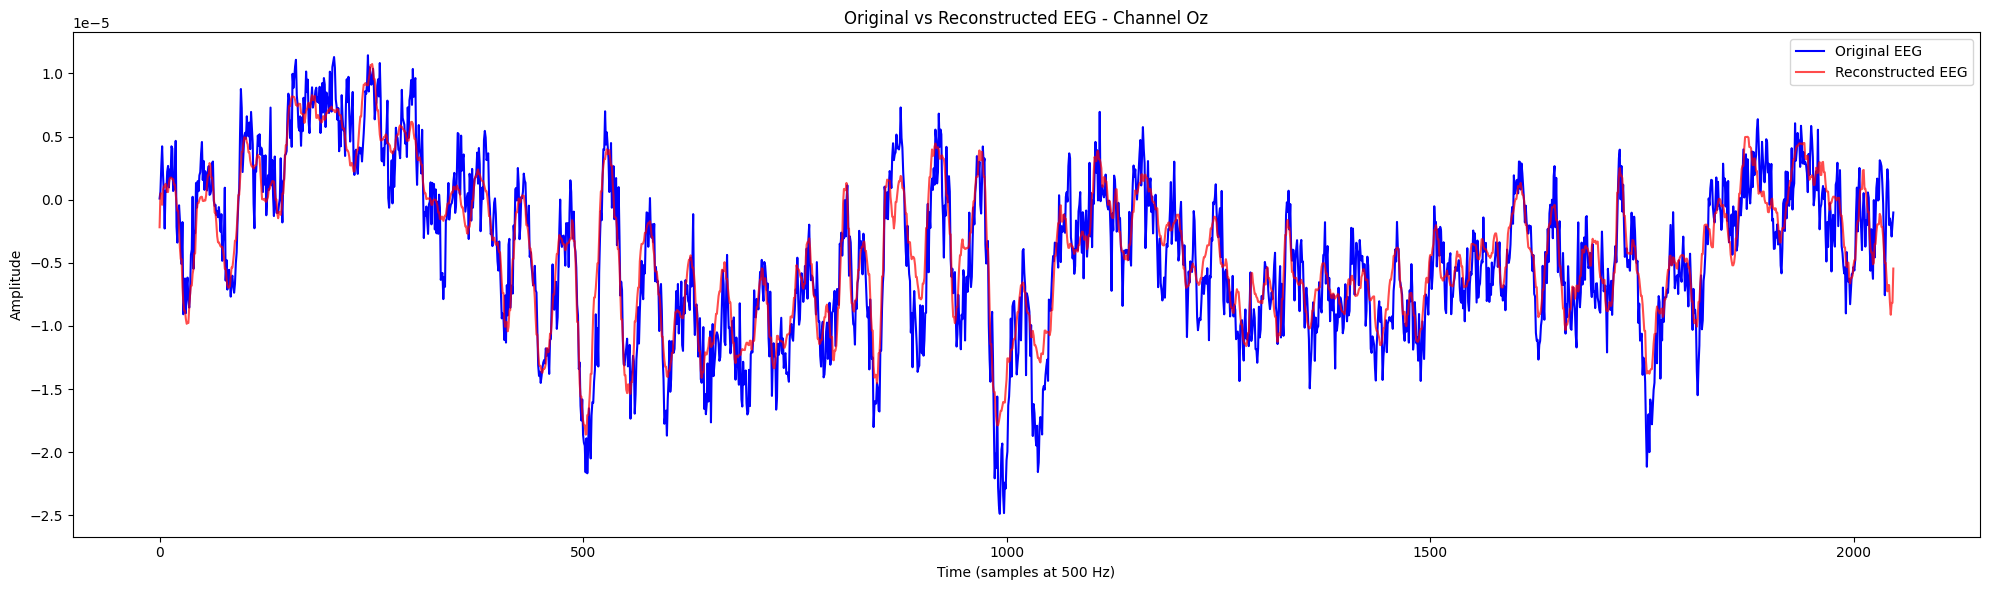

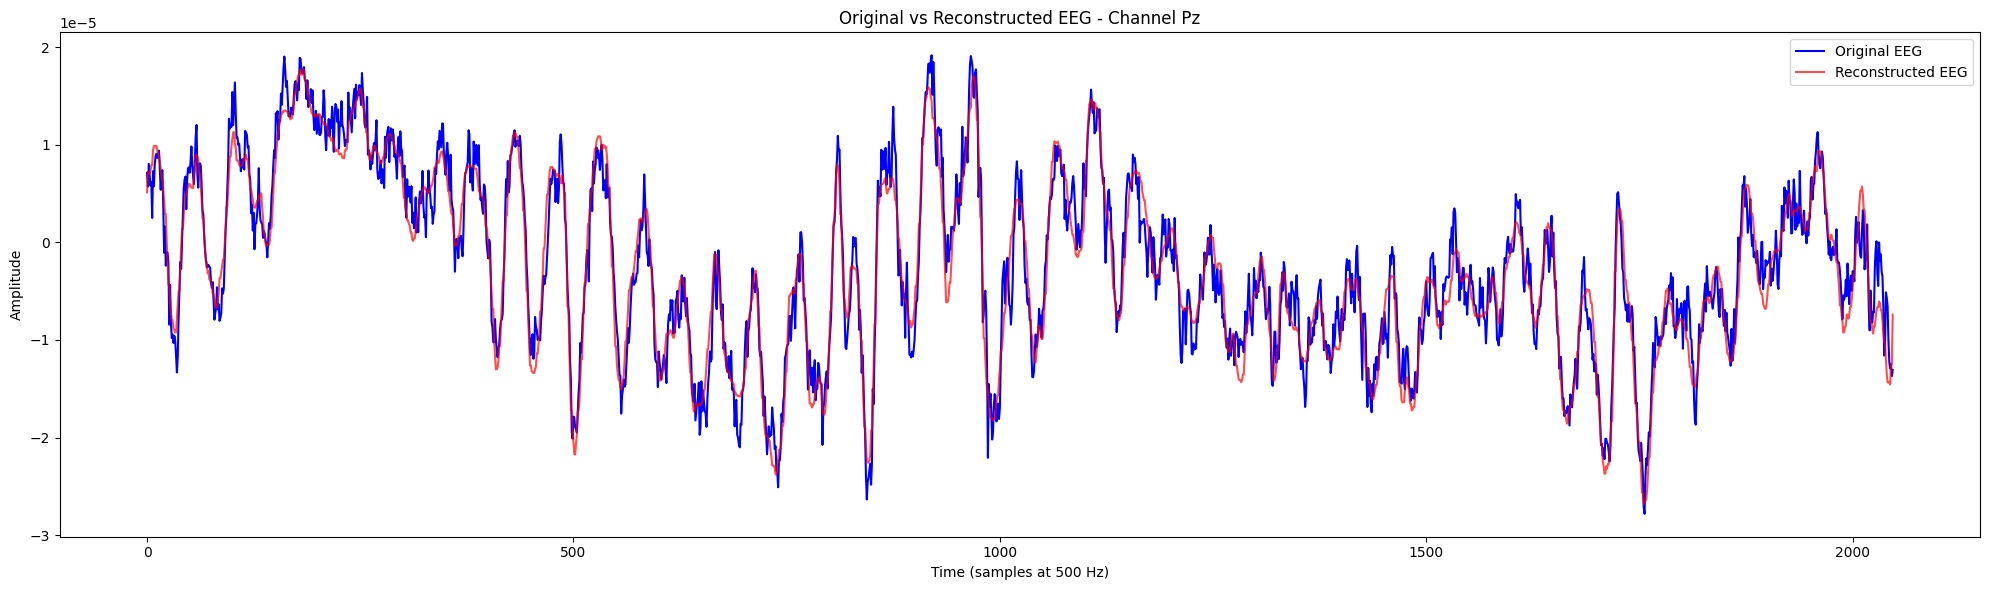

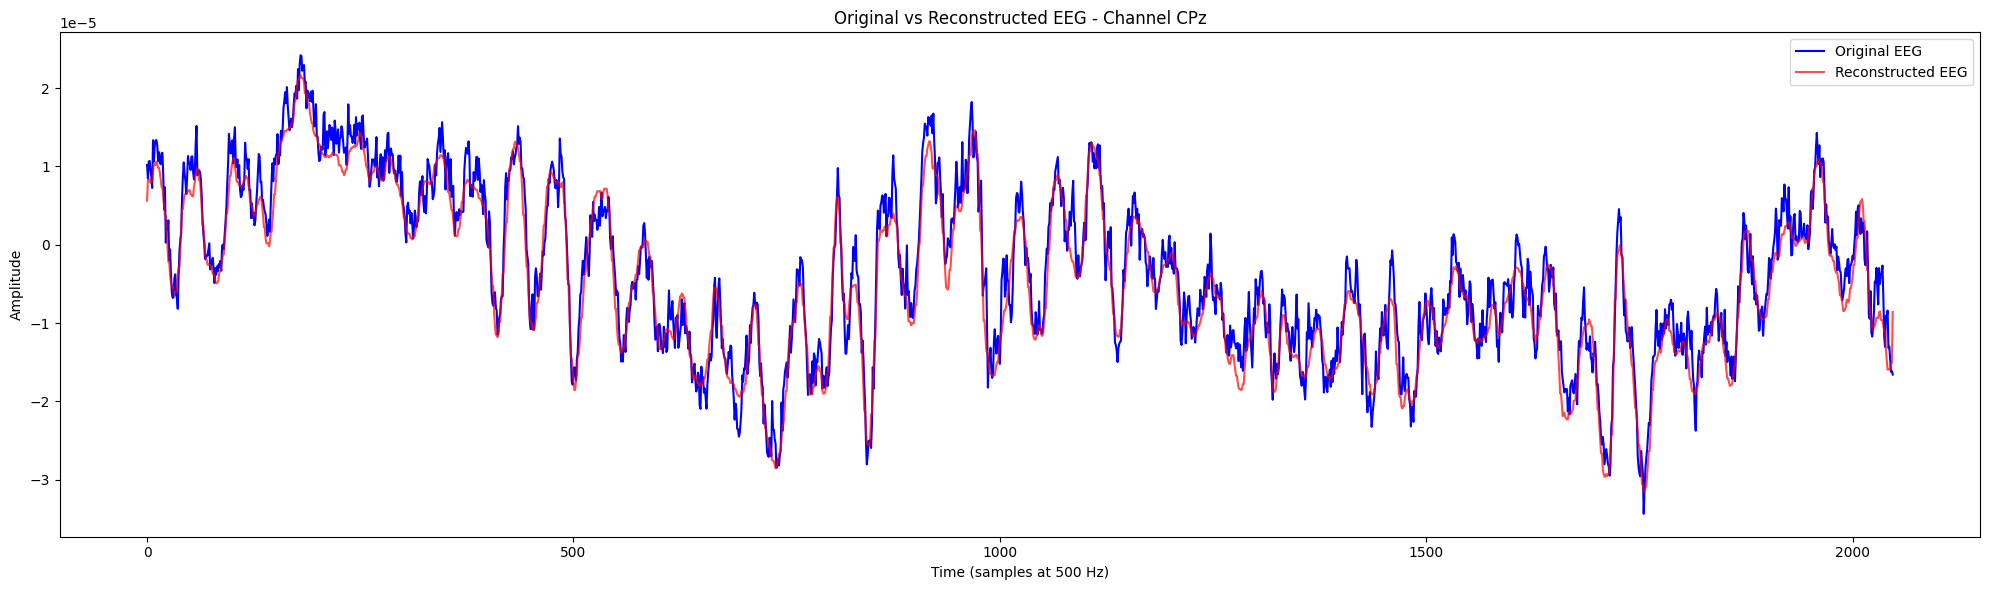

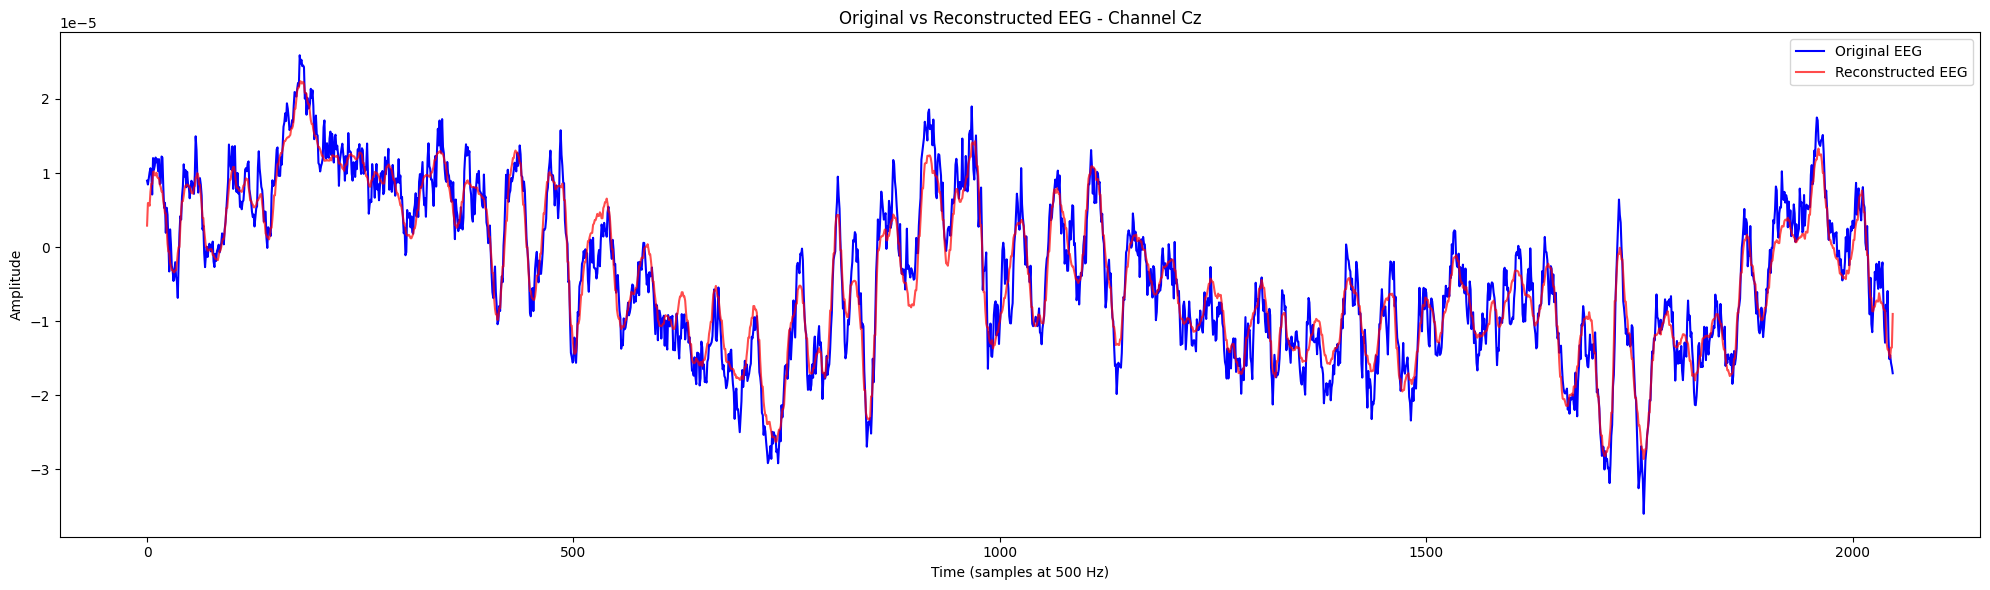

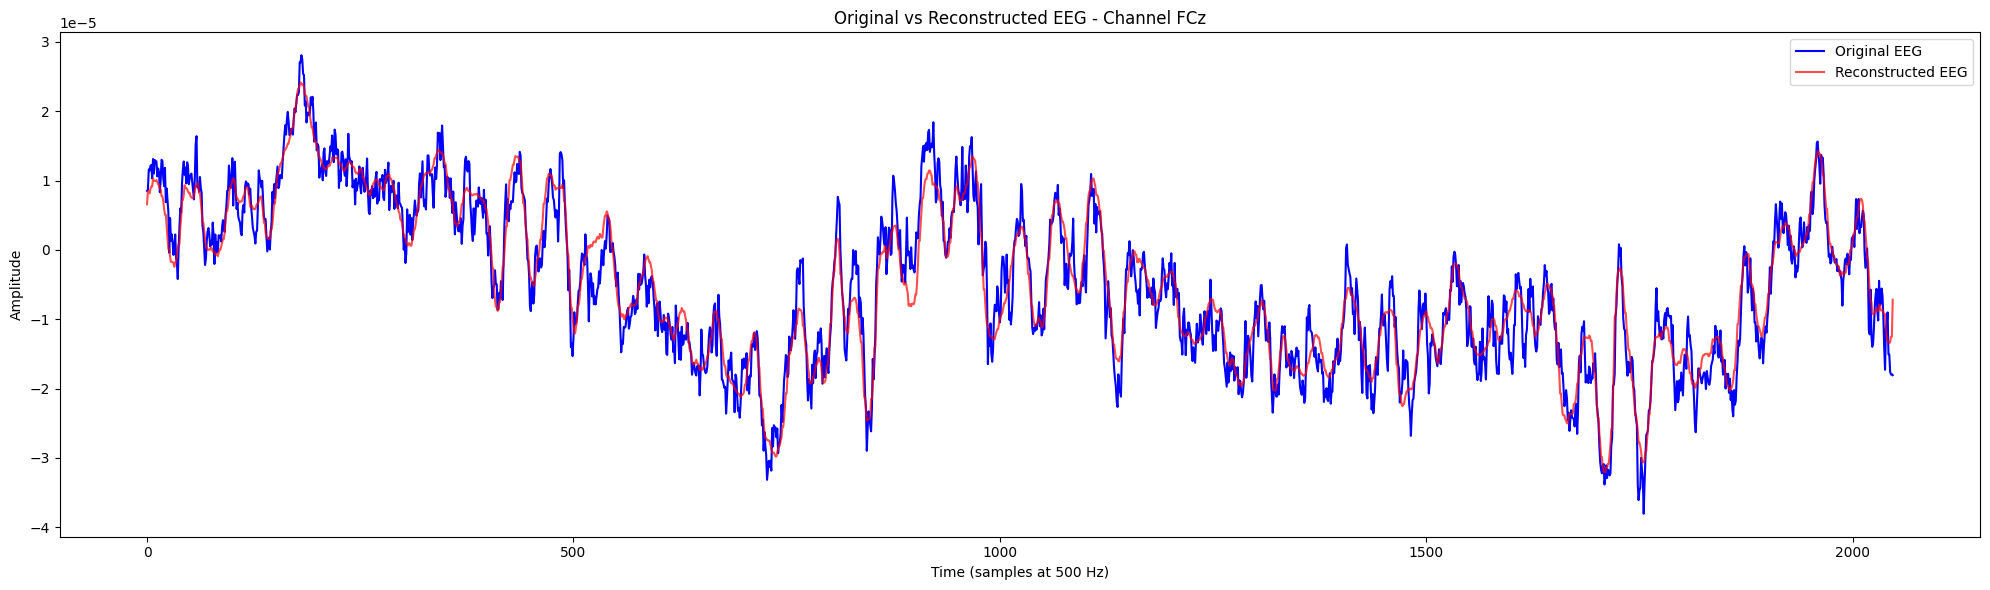

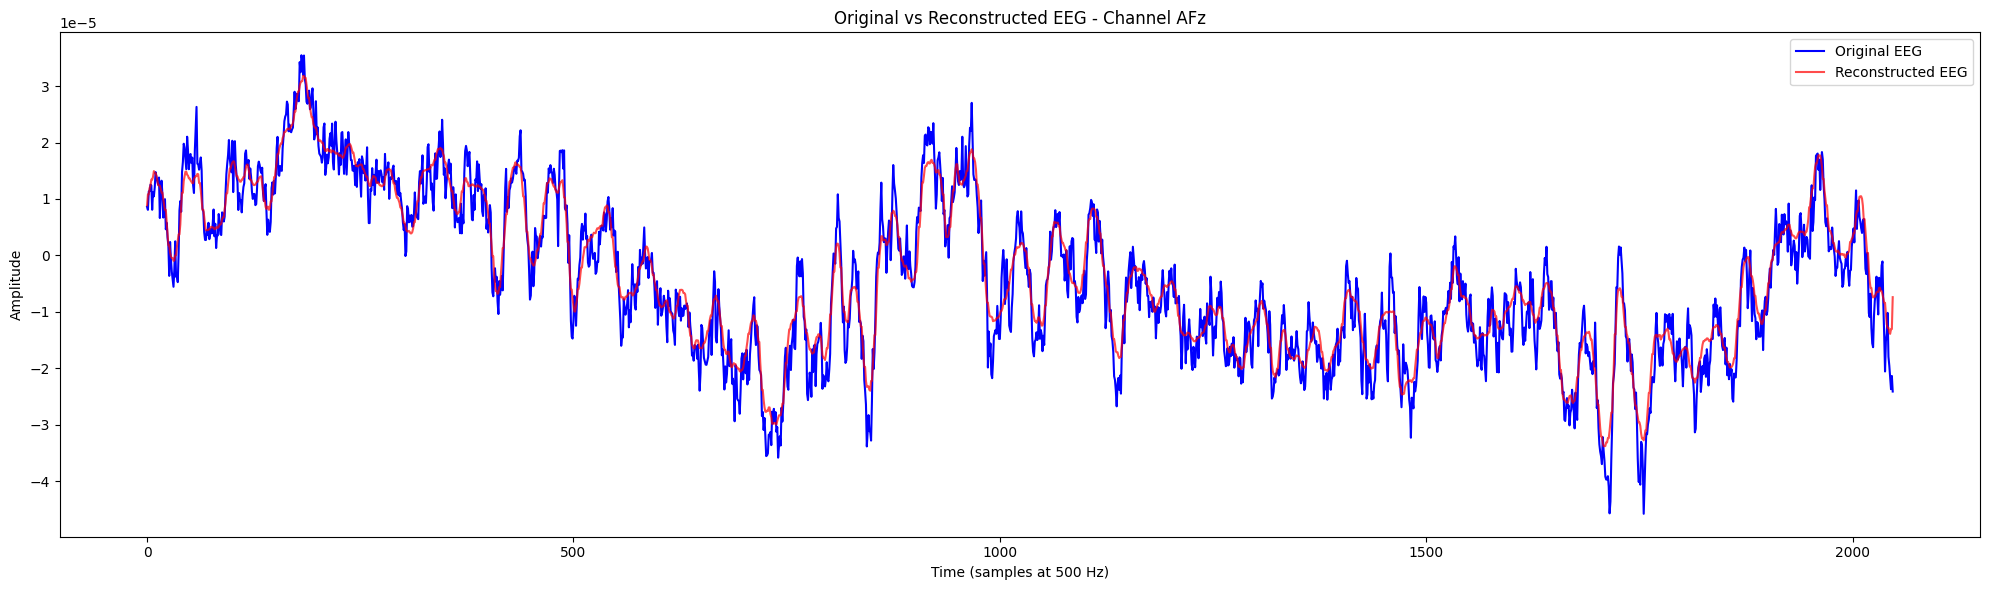

In [ ]:

# List of channel names
channels = ['O1', 'P7', 'P3', 'CP5', 'CP1', 'T7', 'C3', 'FC1', 'FC5', 'F3', 'F7', 'Fp1',
            'O2', 'P8', 'P4', 'CP6', 'CP2', 'C4', 'T8', 'FC2', 'FC6', 'F4', 'F8', 'Fp2',
            'Oz', 'Pz', 'CPz', 'Cz', 'FCz', 'AFz']

# Select sample to visualize
max_samples = SONG_LENGTH  # match your EEG length

for channel_idx, channel_name in enumerate(channels):
    original = test_signal[sample_idx,channel_idx, :max_samples, 0]
    reconstructed = reconstructions[sample_idx,channel_idx, :max_samples, 0]

    plt.figure(figsize=(20,6))
    plt.plot(original, label='Original EEG', color='blue')
    plt.plot(reconstructed, label='Reconstructed EEG', color='red', alpha=0.7)

    plt.title(f'Original vs Reconstructed EEG - Channel {channel_name}')
    plt.xlabel('Time (samples at 500 Hz)')
    plt.ylabel('Amplitude')

    # Show legend only once per label
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

# Model Comparison

Load the models

In [8]:
from tensorflow import keras
base_path = "/content/drive/MyDrive/CMPT 491 EEG Data/models"

model_paths = {
    "AE_3200_batch": f"{base_path}/eeg_autoencoder_3200_decoder_batchNorm.keras",
    "AE_3200": f"{base_path}/eeg_autoencoder_3200.keras",
    "AE_8192_batch": f"{base_path}/eeg_autoencoder_8192_decoder_batchNorm.keras",
    "AE_8192": f"{base_path}/eeg_autoencoder_8192.keras",
}

models = {name: keras.models.load_model(path)
          for name, path in model_paths.items()}

Unseen subject reconstruction

In [45]:
# raw is your original MNE Raw object
channel_names = ['O1', 'P7', 'P3', 'CP5', 'CP1', 'T7', 'C3', 'FC1', 'FC5', 'F3', 'F7', 'Fp1', 'O2', 'P8', 'P4', 'CP6', 'CP2', 'C4', 'T8', 'FC2', 'FC6', 'F4', 'F8', 'Fp2', 'Oz', 'Pz', 'CPz', 'Cz', 'FCz', 'AFz']
print(channel_names)
print(f"Number of channels: {len(channel_names)}")

# We will reconstruct subject 30
sub_30_raw_tensor = tf.io.read_file("/content/drive/My Drive/CMPT 491 EEG Data/sub-30.tfrecord")
sub_30_signal = tf.io.parse_tensor(raw_tensor, out_type=tf.float32)

sub_30_signal  = np.transpose(sub_30_signal, (0, 2, 3, 1))
# Uses min and max vals from training set
sub_30_signal_norm  = 2 * (sub_30_signal - min_val) / (max_val - min_val + 1e-8) -1

In [46]:
reconstructions = {}

for name, model in models.items():
    recon_norm = model.predict(sub_30_signal_norm, verbose=0)

    # Undo min–max normalization
    recon = (recon_norm + 1) / 2 * (max_val - min_val) + min_val

    reconstructions[name] = recon

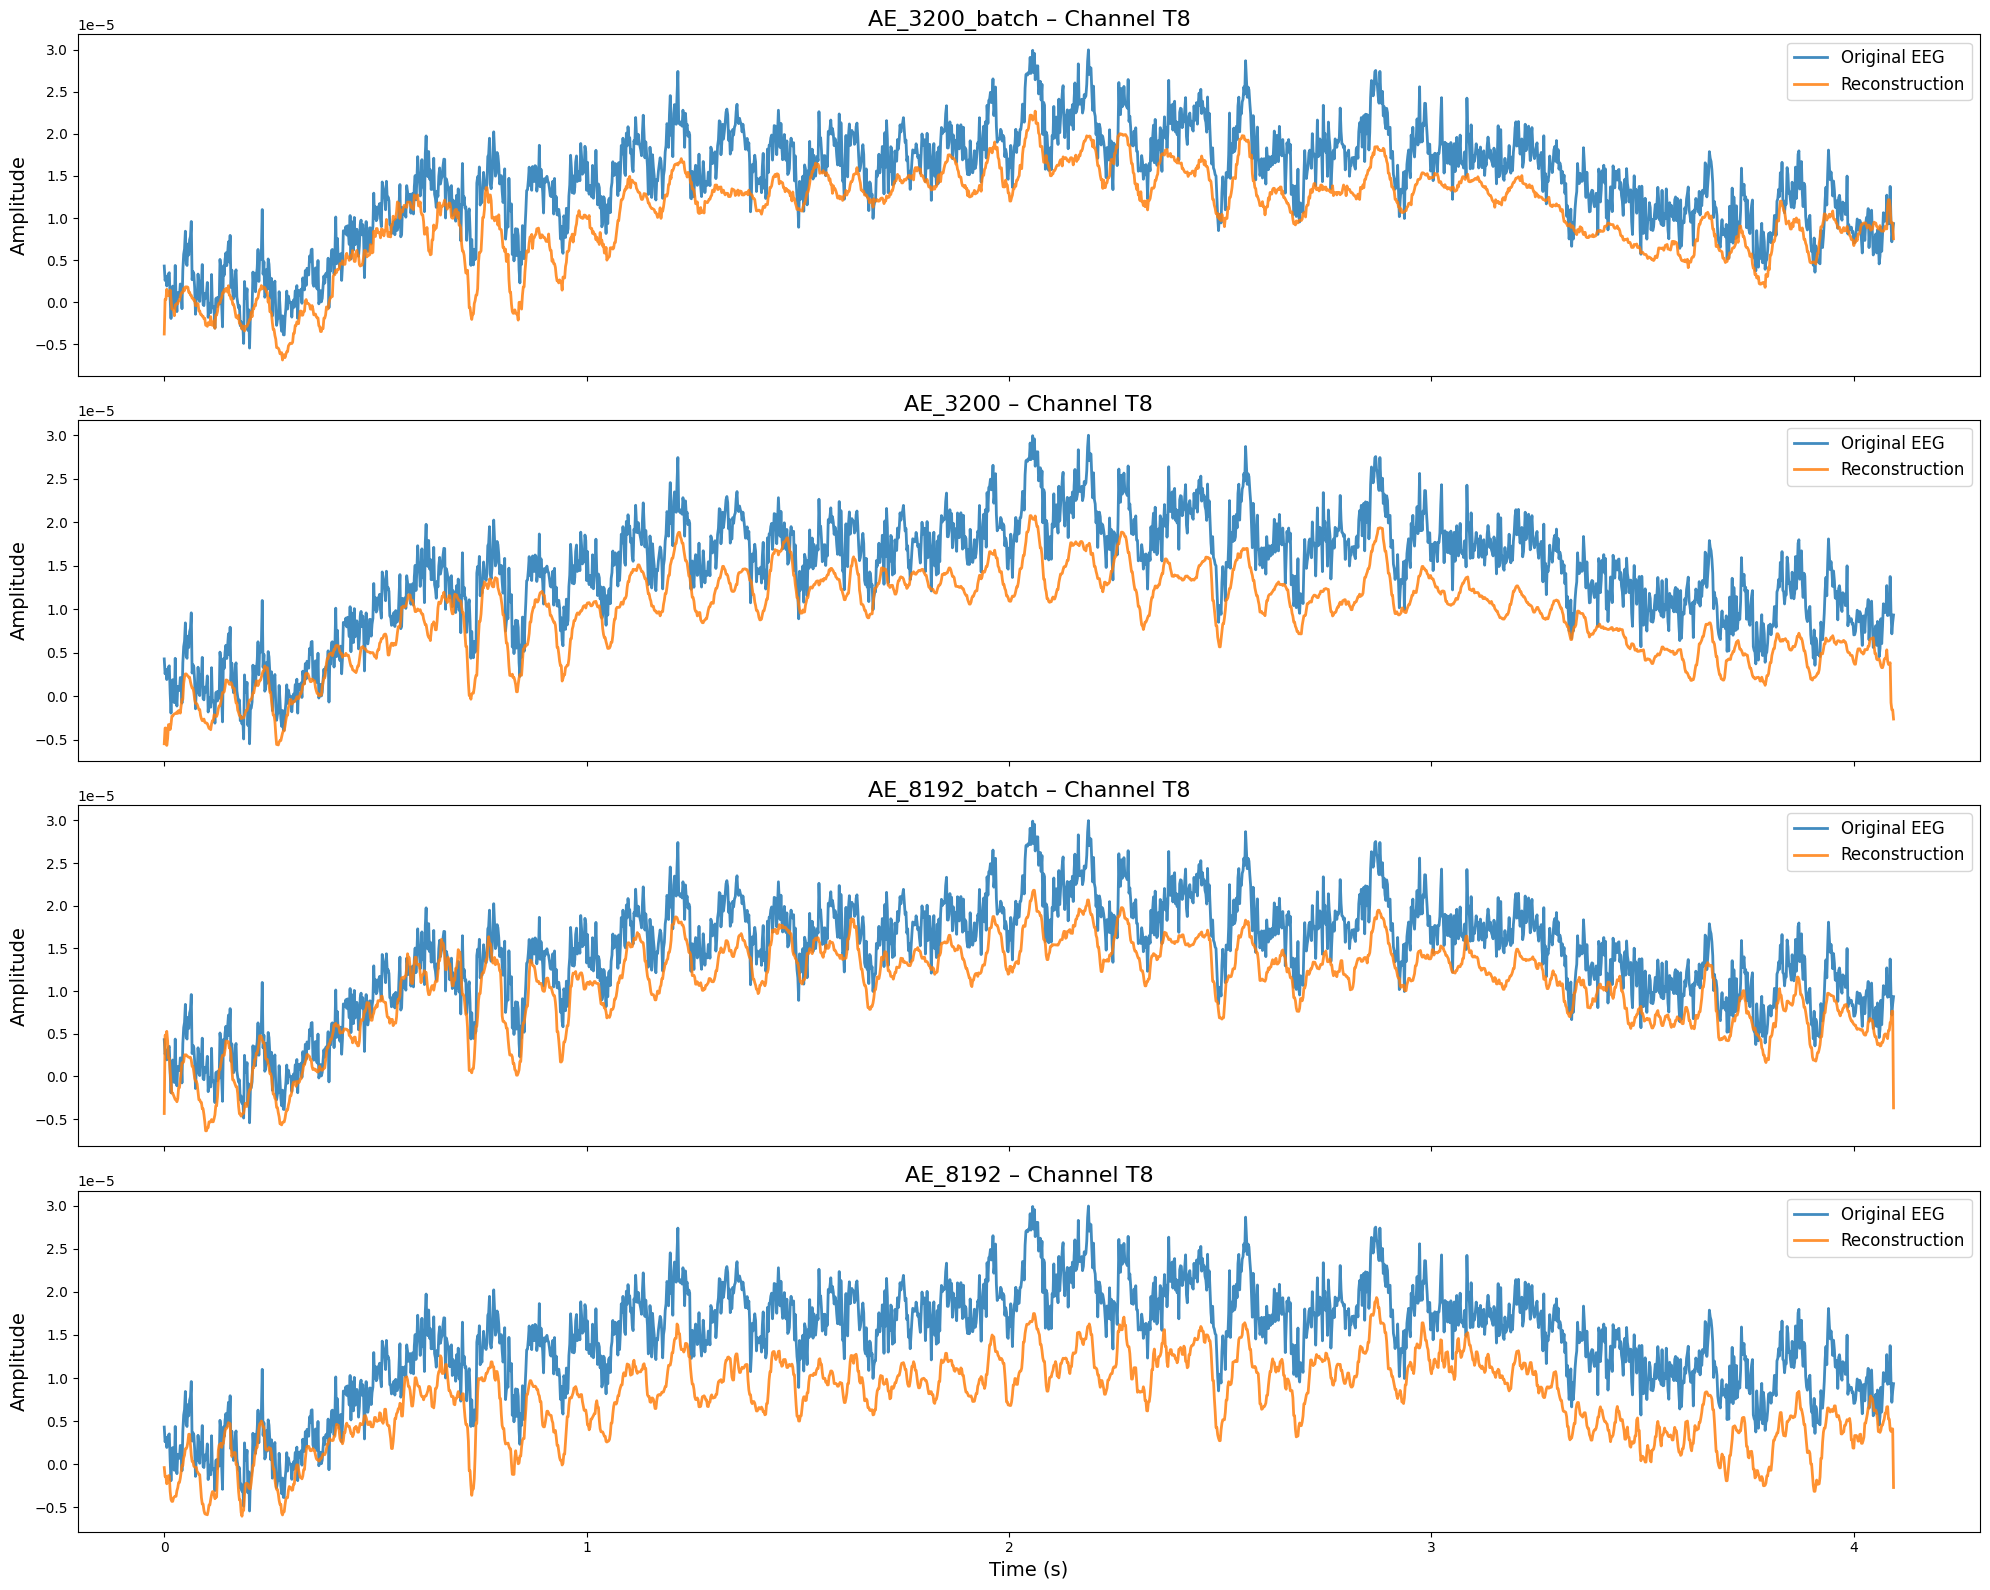

In [53]:
sample_idx = 0
channel_idx = 18   # 5 = T7, 18 = T8
channel_name = "T8"

# Full signal
full_len = sub_30_signal.shape[2]
time = np.arange(full_len) / SF
original = sub_30_signal[sample_idx, channel_idx, :, 0]

n_models = len(reconstructions)
fig, axes = plt.subplots(
    n_models, 1,
    figsize=(20, 4 * n_models),
    sharex=True
)

if n_models == 1:
    axes = [axes]

for ax, (name, recon) in zip(axes, reconstructions.items()):
    reconstructed = recon[sample_idx, channel_idx, :, 0]

    ax.plot(time, original, label="Original EEG", linewidth=2, alpha=0.85)
    ax.plot(time, reconstructed, label="Reconstruction", linewidth=2, alpha=0.85)

    ax.set_title(f"{name} – Channel {channel_name}", fontsize=16)
    ax.set_ylabel("Amplitude", fontsize=14)
    ax.legend(fontsize=12)

axes[-1].set_xlabel("Time (s)", fontsize=14)

plt.tight_layout()

plt.show()

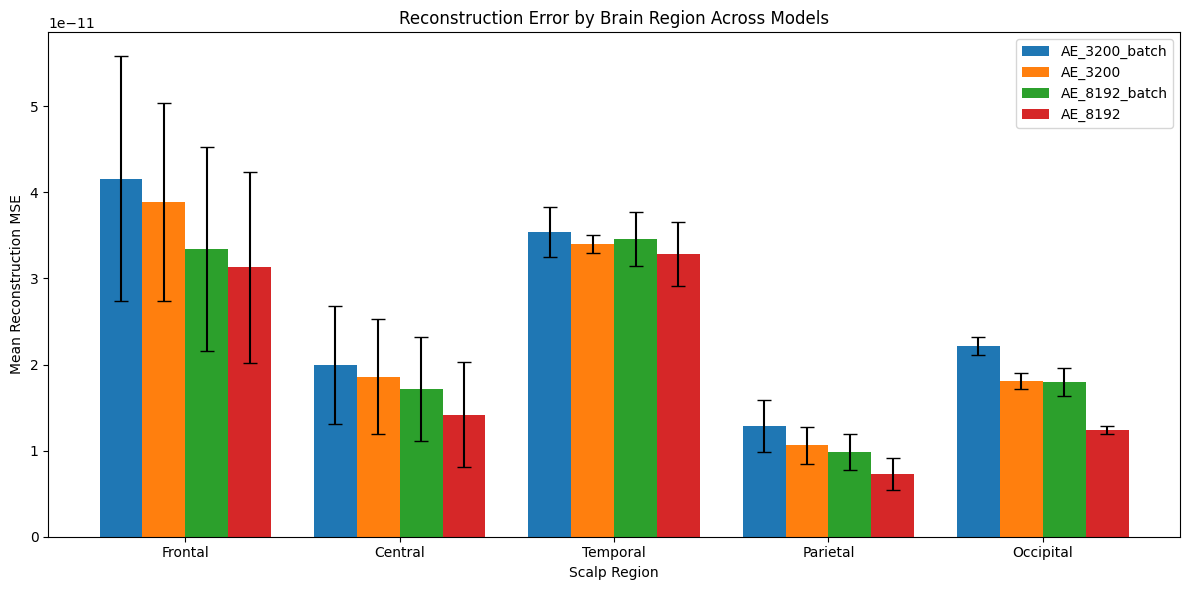

In [35]:
# Define regions
REGIONS = {
    "Frontal":   ["Fp1", "Fp2", "F3", "F4", "F7", "F8", "Fz"],
    "Central":   ["C3", "C4", "Cz"],
    "Temporal":  ["T7", "T8"],
    "Parietal":  ["P3", "P4", "Pz"],
    "Occipital": ["O1", "O2"]
}

# Get channel names from your data
ch_names = raw_array[0].info['ch_names']

# Prepare storage for plotting
region_means = {region: [] for region in REGIONS}
region_stds  = {region: [] for region in REGIONS}
model_names  = list(models.keys())

# Loop over models and compute MSE per channel, then aggregate per region
for name, recon in reconstructions.items():
    # Compute per-channel MSE
    channel_mse = np.mean((sub_30_signal - recon) ** 2, axis=(0,2,3))

    # Compute region-wise mean & std
    for region, channels in REGIONS.items():
        idx = [i for i, ch in enumerate(ch_names) if ch in channels]
        vals = channel_mse[idx]
        region_means[region].append(vals.mean())
        region_stds[region].append(vals.std())

# Plot grouped bar chart
regions = list(REGIONS.keys())
x = np.arange(len(regions))
width = 0.2

plt.figure(figsize=(12, 6))

for i, model_name in enumerate(model_names):
    means = [region_means[r][i] for r in regions]
    stds  = [region_stds[r][i] for r in regions]
    plt.bar(x + i*width, means, width=width, yerr=stds, capsize=5, label=model_name)

plt.xticks(x + width*(len(model_names)-1)/2, regions)
plt.ylabel("Mean Reconstruction MSE")
plt.xlabel("Scalp Region")
plt.title("Reconstruction Error by Brain Region Across Models")
plt.legend()
plt.tight_layout()
plt.show()

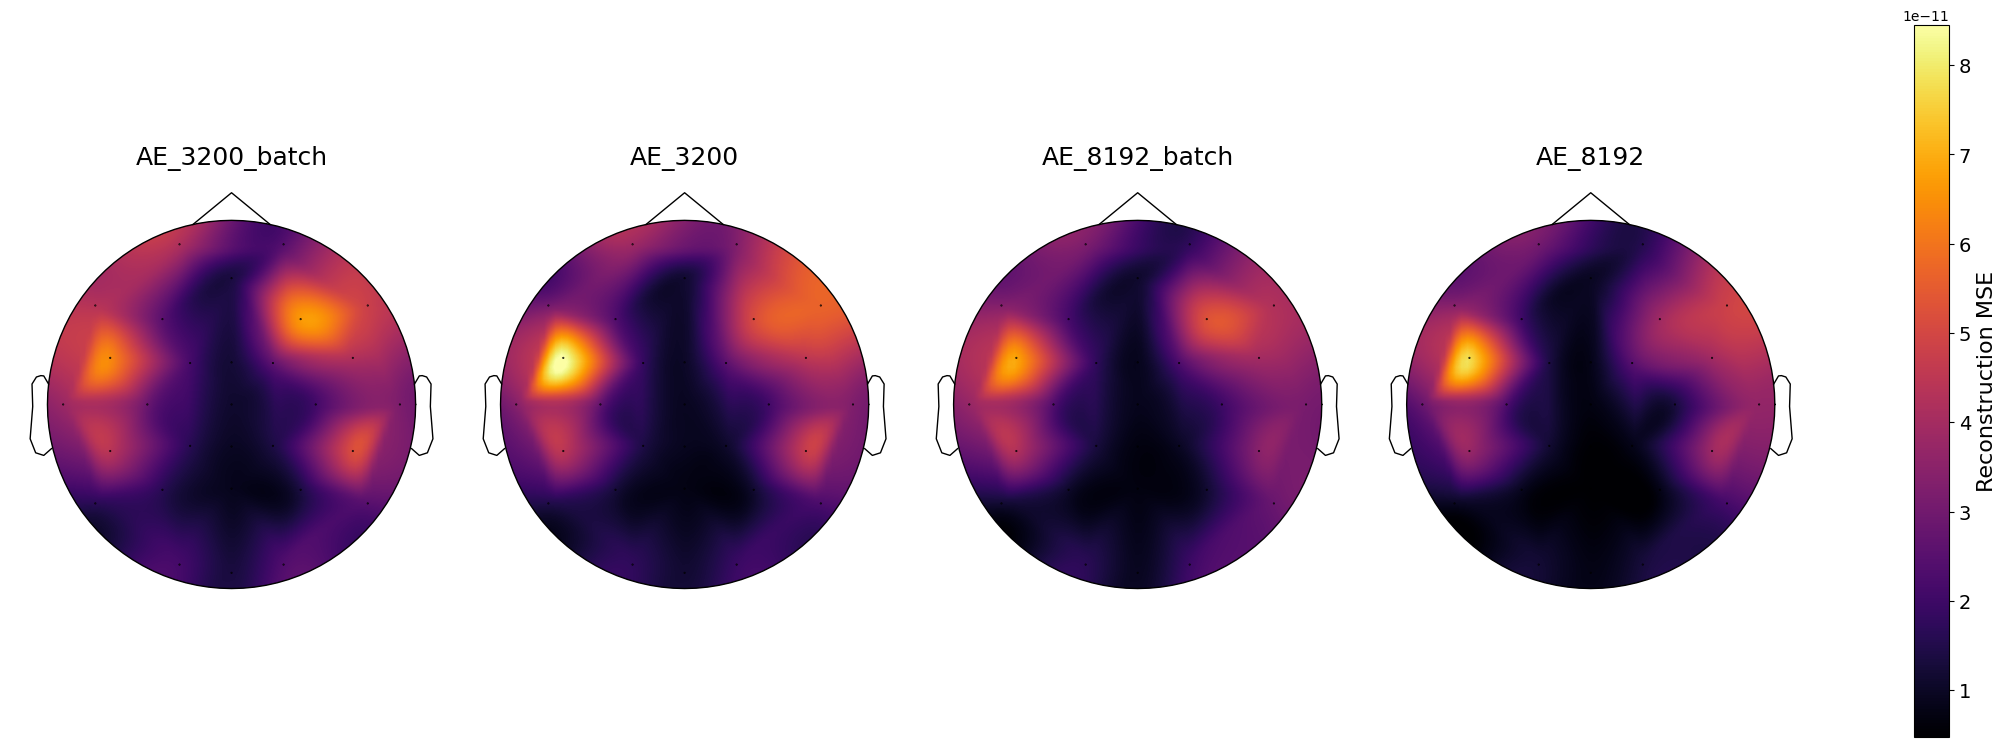

In [38]:
# Compute per-channel MSE for each model on the unseen subject
results_sub30 = {}

for name, recon in reconstructions.items():
    # channel-wise MSE: mean over samples and time
    channel_mse = np.mean((sub_30_signal - recon) ** 2, axis=(0, 2, 3))
    results_sub30[name] = {"channel_mse": channel_mse}

# Plot heatmaps
fig, axes = plt.subplots(1, len(models), figsize=(20, 8), layout="constrained")

vmin = min(np.min(results_sub30[m]["channel_mse"]) for m in results_sub30)
vmax = max(np.max(results_sub30[m]["channel_mse"]) for m in results_sub30)

for ax, (name, res) in zip(axes, results_sub30.items()):
    im = mne.viz.plot_topomap(
        res["channel_mse"],
        raw_array[0].info,
        axes=ax,
        show=False,
        cmap="inferno",
        contours=0,
        vlim=(vmin, vmax)
    )[0]
    ax.set_title(name, fontsize=18)

cbar = fig.colorbar(im, ax=axes, shrink=0.9)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("Reconstruction MSE", fontsize=16)
plt.show()

In [42]:
results = {}
for name, model in models.items():
    loss, mae = model.evaluate(sub_30_signal_norm, sub_30_signal_norm, verbose=0)
    results[name] = {"test_mse": loss}
results

{'AE_3200_batch': {'test_mse': 0.001319084782153368},
 'AE_3200': {'test_mse': 0.0012041141744703054},
 'AE_8192_batch': {'test_mse': 0.0010687356116250157},
 'AE_8192': {'test_mse': 0.0009369868785142899}}